# Exercises: Analyzing Hyperpolarized Data

## Install code, setup path

To run this code you will need to clone the hyperpolarized MRI toolbox
repository from github and add it to your matlab path. 
This can be done with the following command:
'git clone https://github.com/LarsonLab/hyperpolarized-mri-toolbox/'

This also requires the Optimization Toolbox (Matlab) or 'optim' toolbox (Octave) for the kinetic model fitting and Image Processing Toolbox ('image' in Octave) for plots


In [7]:
imatlab_export_fig('print-jpeg')  % setup for inline figures

In [2]:
% setup hyperpolarized-mri-toolbox
cd ../
if exist('startup.m')
    startup
else
    cd ../
    startup
end

## Exercise: Load and visualize a HP imaging dataset



In [1]:
%% Load an imaging dataset
% sample_data available in toolbox
% Easiest: rat or mouse EPI data (single channel RF coil)
% Challenge: Human Brain EPI (multi-channel coil, need to implement coil combination)
clear all;
load('sample_data\Rat Kidneys EPI\exp2_constant\exp2_constant.mat')

% lists all variables
whos

  Name            Size                Bytes  Class     Attributes

  TR              1x1                     8  double              
  flips_lac      25x1                   200  double              
  flips_pyr      25x1                   200  double              
  lac            32x32x25            102400  single              
  pyr            32x32x25            102400  single              



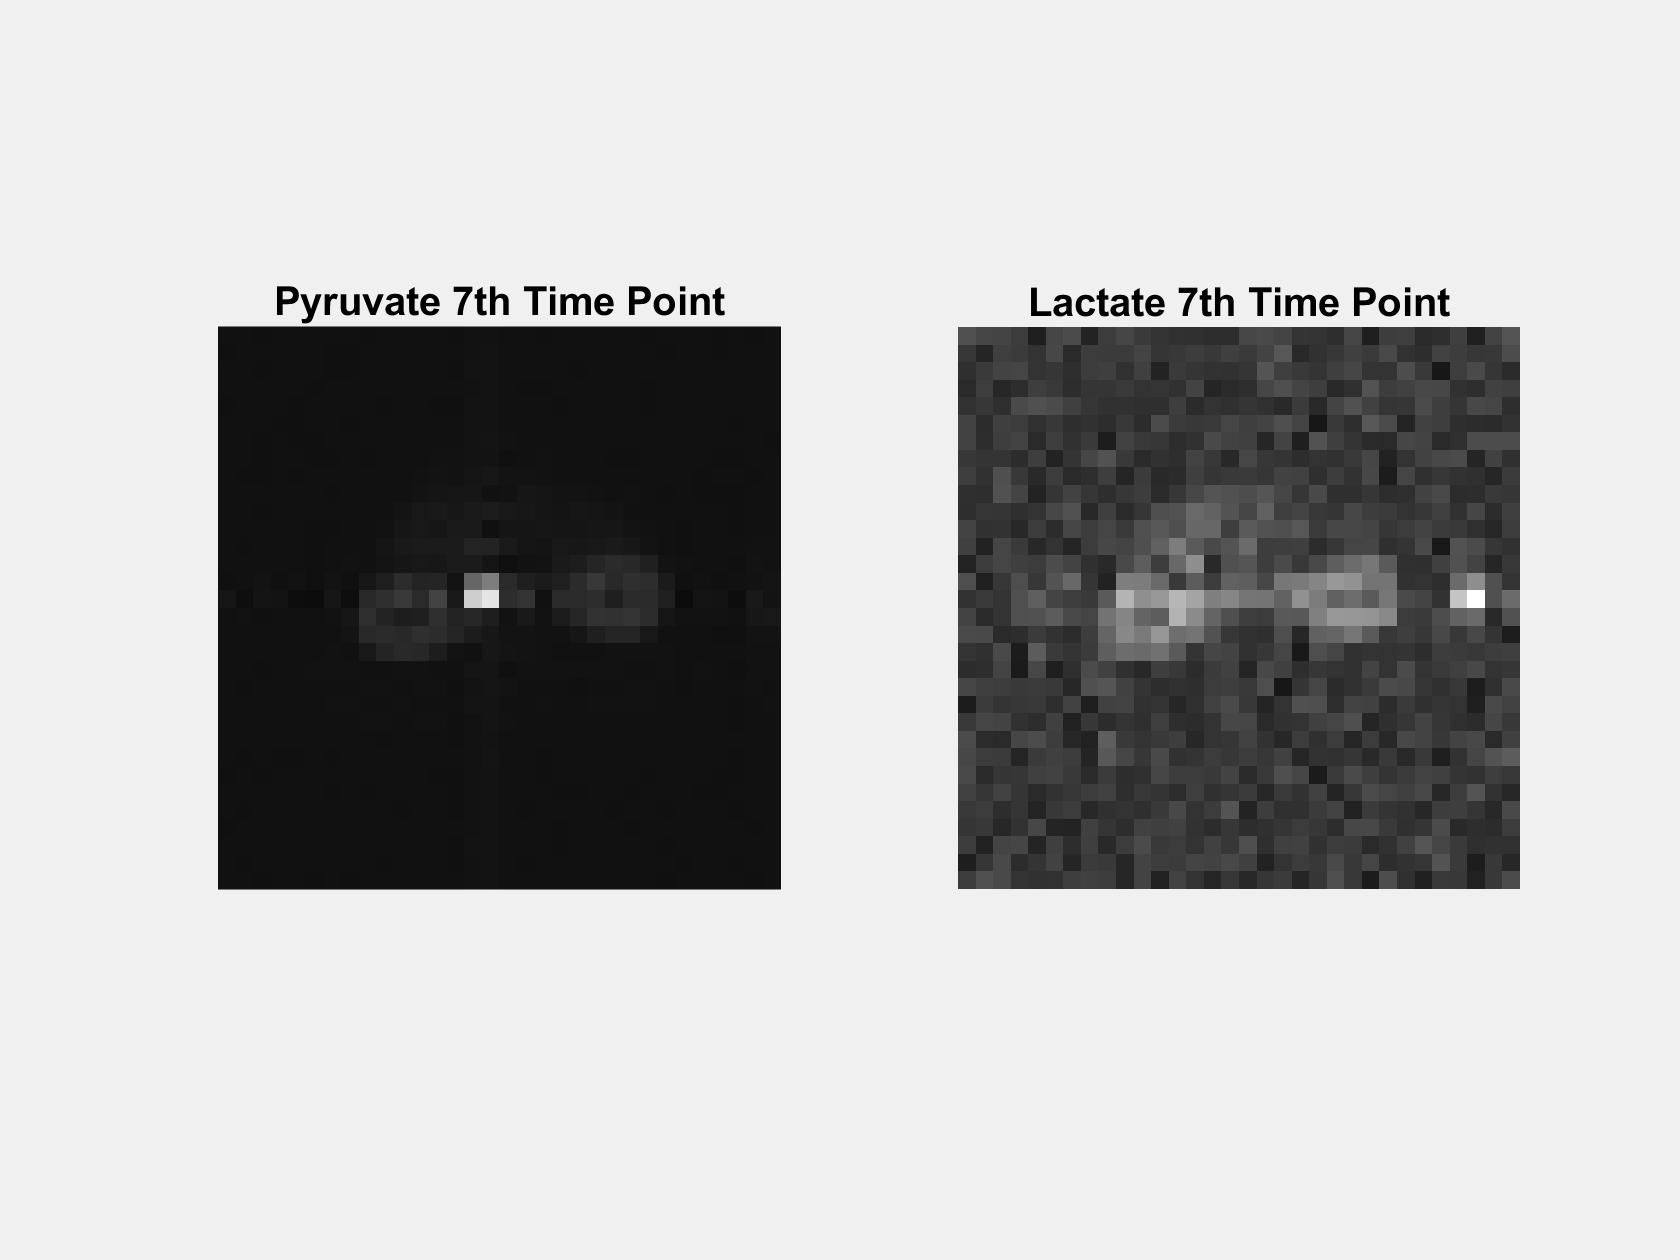

In [151]:
%% Visualize dataset
% for all, find areas that have signal

% 1. display an image from each metabolite at a single time-point
figure()
subplot(121)
imshow(pyr(:,:,7), [min(pyr(:)) max(pyr(:))])
title('Pyruvate 7th Time Point')
subplot(122)
imshow(lac(:,:,7), [min(lac(:)) max(lac(:))])
title('Lactate 7th Time Point')

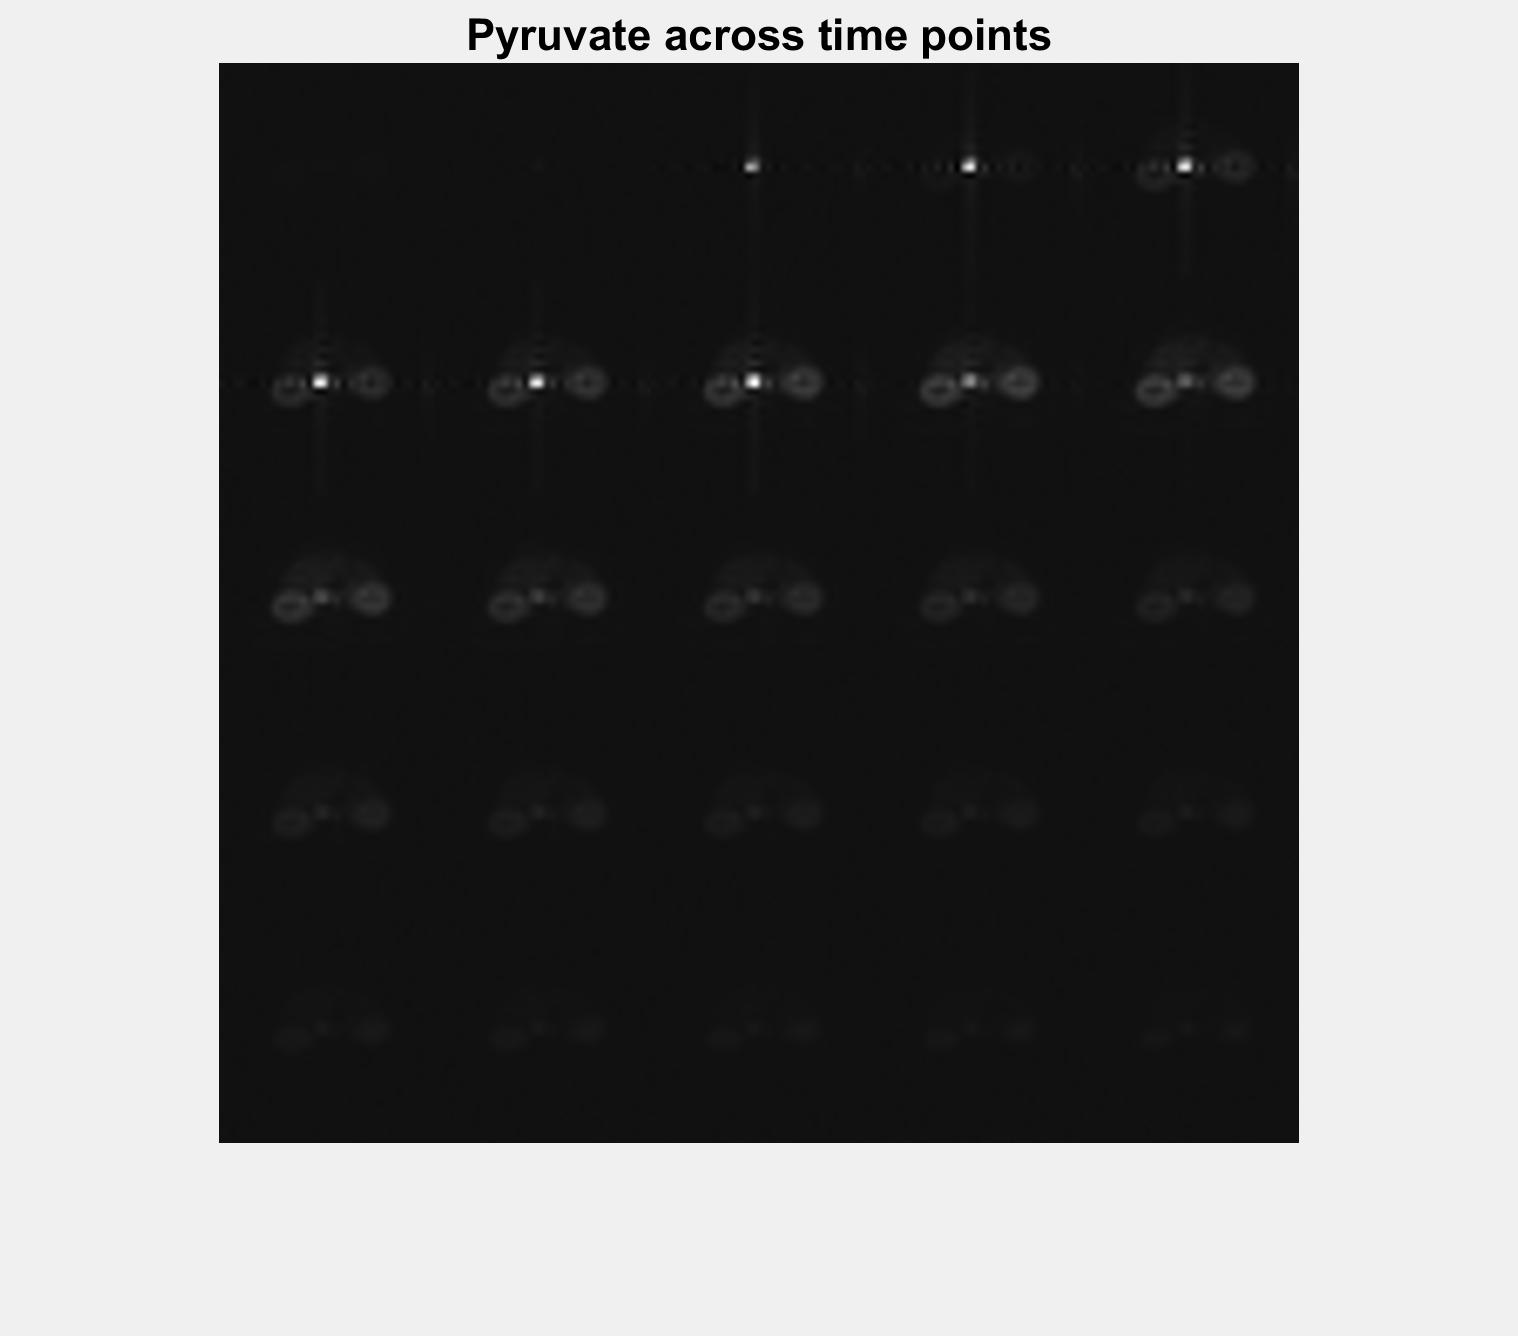

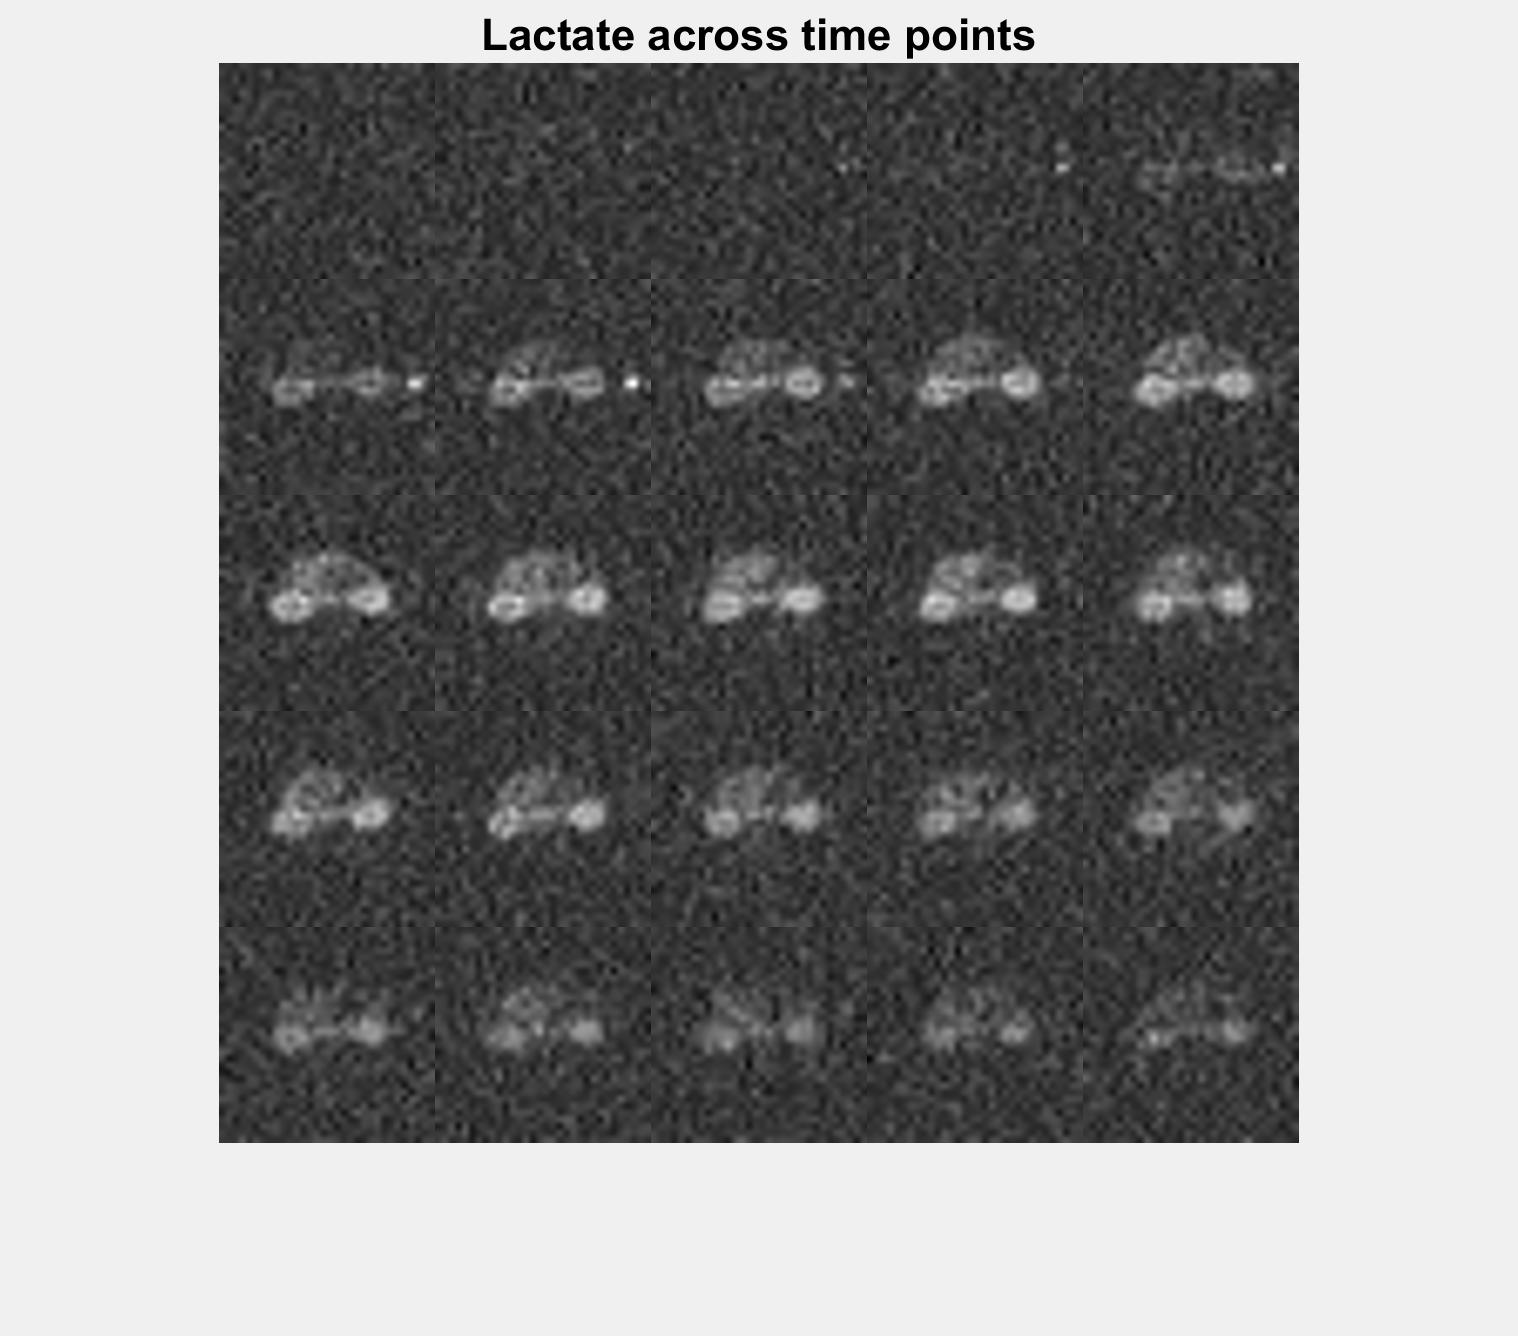

In [152]:
% 2. display all slices and/or timepoints for a single metabolite

% montage() command is useful, but expects a MxNx1xP matrix for grayscale images
% so use something like this to add a singleton dimension to data:
% data_for_montage = permute(data, [1 2 ndims(data)+1 plot_dimension])

pyr_montage = permute(pyr, [1 2 4 3]);
lac_montage = permute(lac, [1 2 4 3]);

figure()
montage(pyr_montage, 'DisplayRange', [min(pyr(:)) max(pyr(:))])
title('Pyruvate across time points')

figure()
montage(lac_montage, 'DisplayRange', [min(lac(:)) max(lac(:))])
title('Lactate across time points')


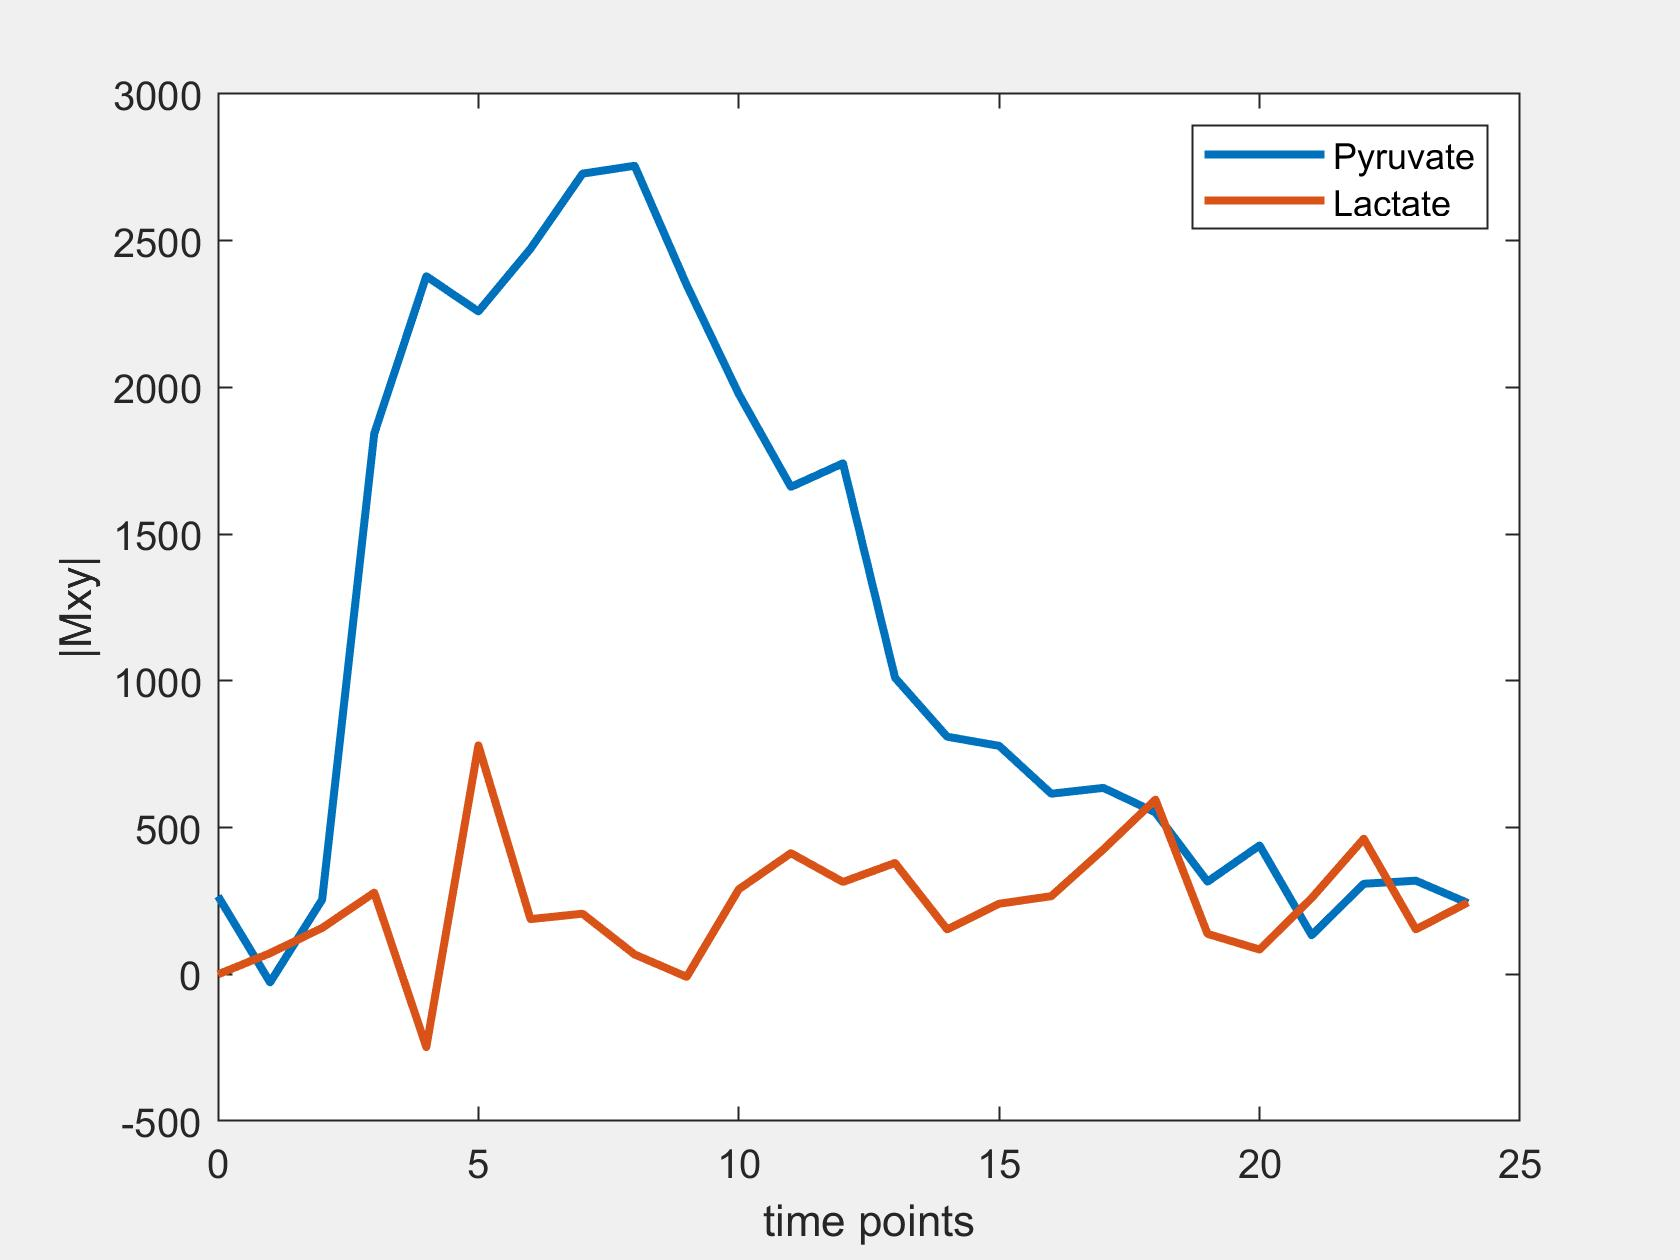

In [153]:
% 3. extract the time curves for all metabolites from a single voxel, and plot versus time

vx = [21, 17]; %arbitratrily pick one of the voxel with signal
pyr_time = squeeze(pyr(vx(1), vx(2), :));
lac_time = squeeze(lac(vx(1), vx(2), :));
Nt = size(pyr,3); % number of time points
time = 0:Nt-1;

figure()
plot(time, pyr_time, time, lac_time, 'LineWidth', 2)
legend('Pyruvate', 'Lactate')
xlabel('time points')
ylabel('|Mxy|')

## Exercise: Model-free Metrics

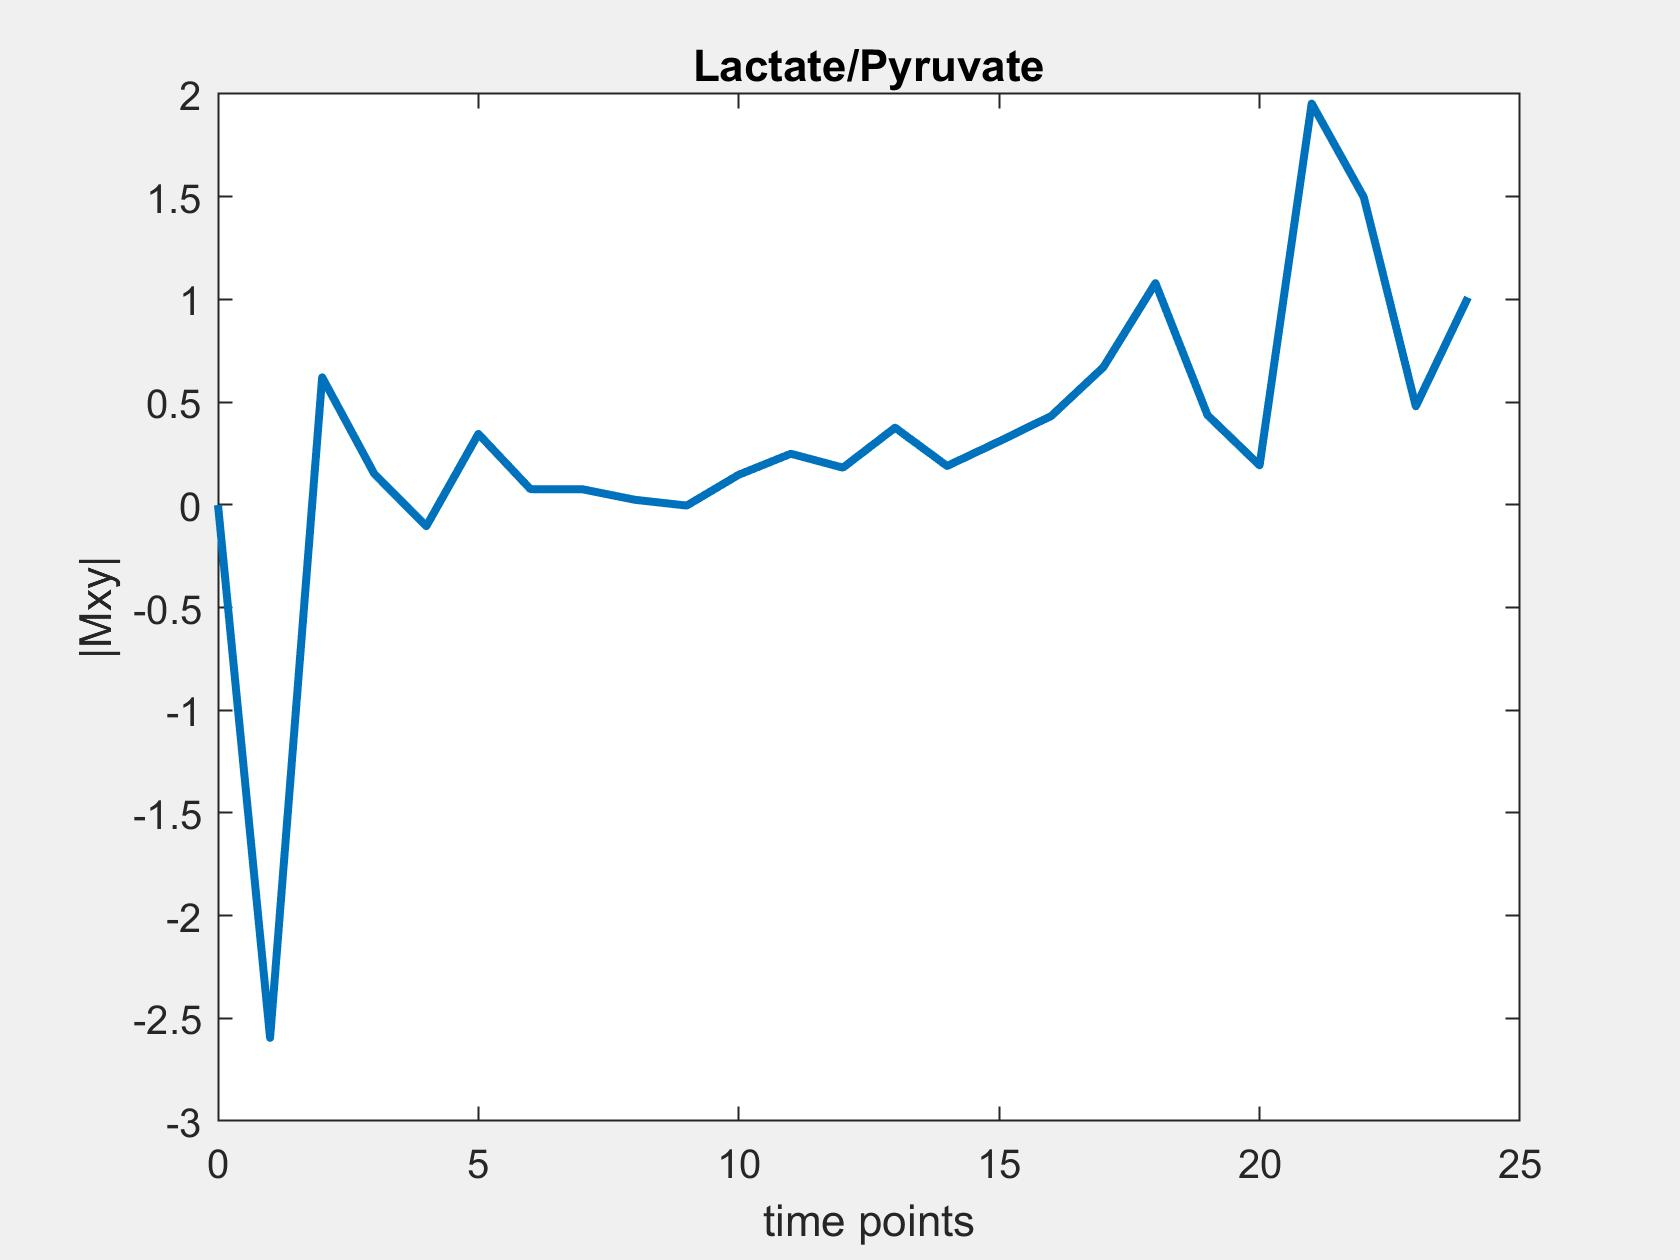

In [155]:
%% Plot Lactate/Pyruvate vs time for a single voxel 

vx = [21, 17]; %arbitratrily pick one of the voxel with signal
pyr_time = squeeze(pyr(vx(1), vx(2), :));
lac_time = squeeze(lac(vx(1), vx(2), :));
Nt = size(pyr,3); % number of time points
time = 0:Nt-1;

figure()
plot(time, lac_time./pyr_time, 'LineWidth', 2)
xlabel('time points')
ylabel('|Mxy|')
title('Lactate/Pyruvate')

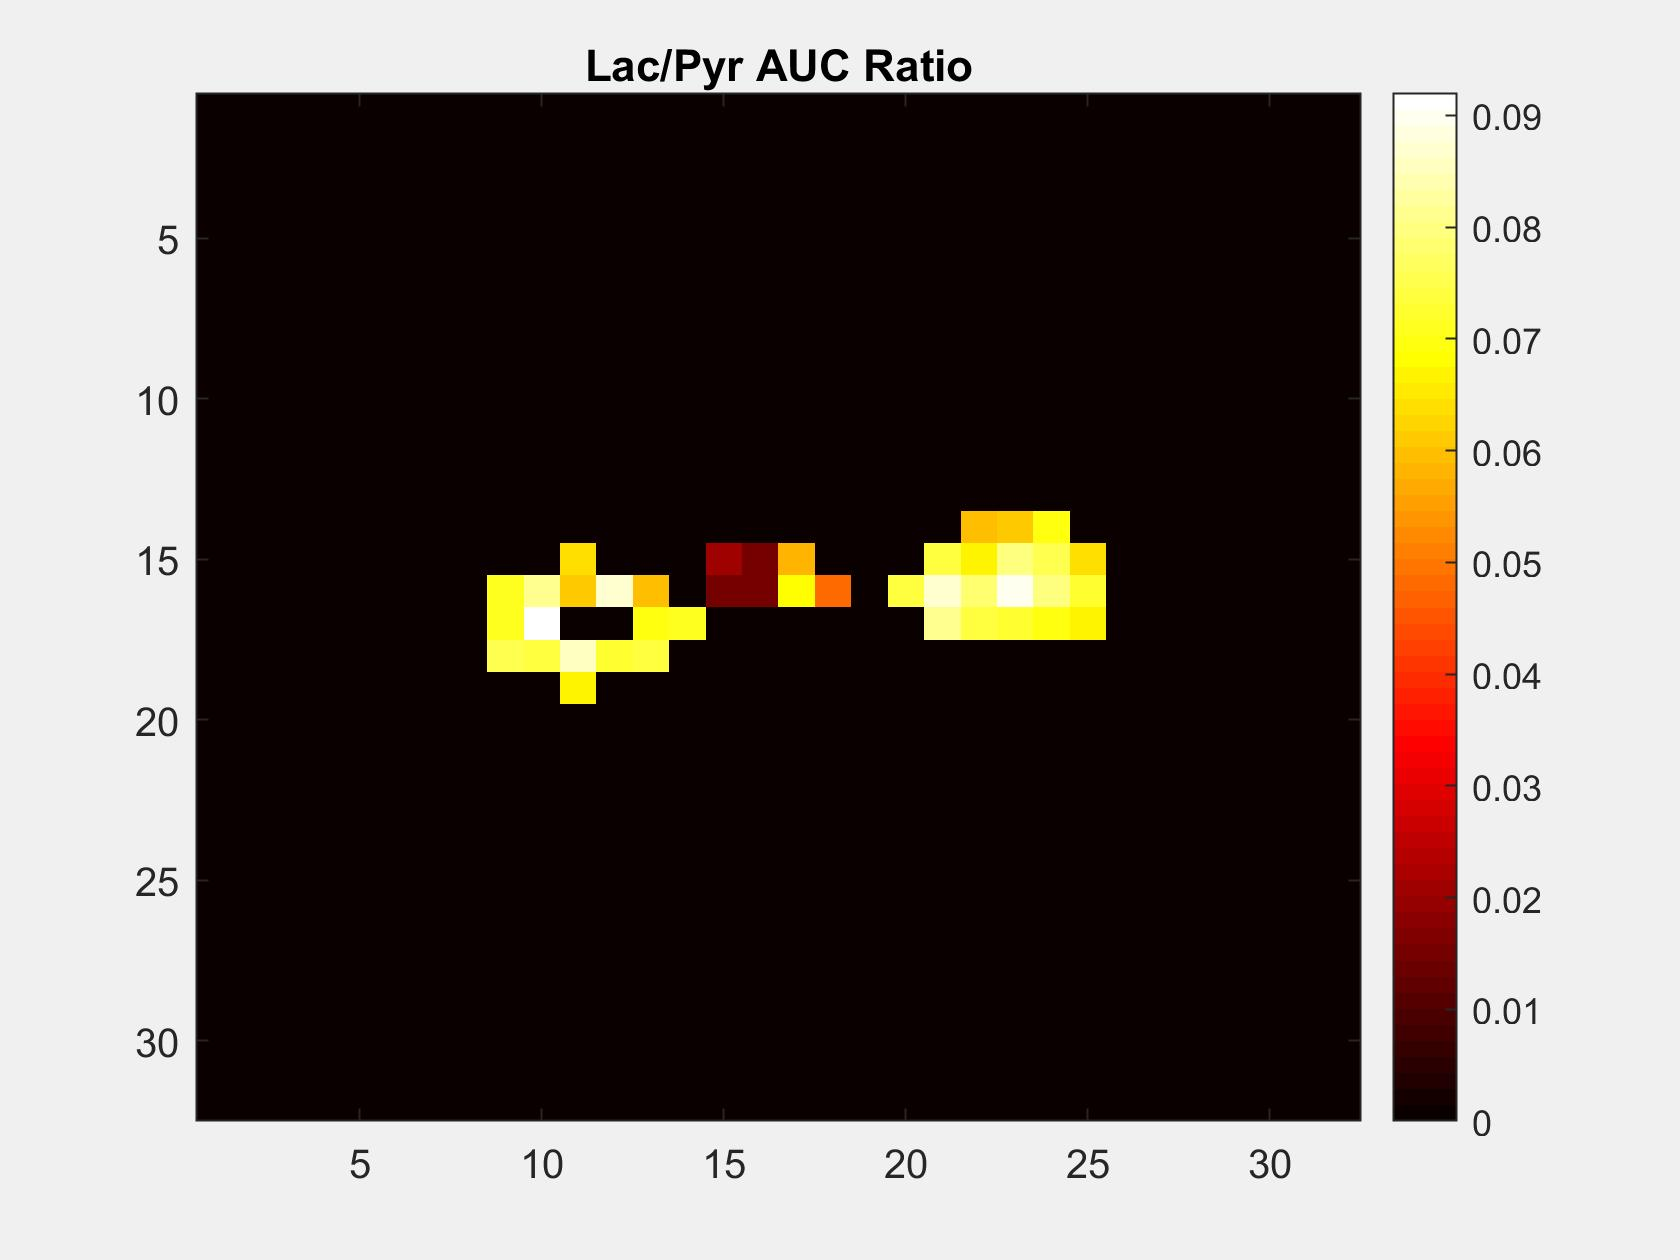

In [173]:
%% Display an image of the AUCratio for each slice
% use compute_AUCratio()
% create a signal mask to only show relevant voxels

S = cat(3, pyr_montage, lac_montage);

% mask out voxels that do not have sufficient pyruvate SNR
nx = size(pyr, 1); ny = size(pyr, 2);
pyr_AUC = sum(pyr, 3);
pyr_max = max(pyr_AUC(:));
ind = find(pyr_AUC >= 0.15*pyr_max); 
S_flat = reshape(S, [nx*ny, size(S,3), size(S,4)]);
S_masked = S_flat(ind, :, :);

AUCratio = compute_AUCratio(S_masked);

%construct AUC map
AUC_map = zeros([nx*ny, 1]);
AUC_map(ind) = AUCratio;
AUC_map = reshape(AUC_map, [nx ny]);

figure()
imagesc(AUC_map)
colormap('hot')
colorbar
title('Lac/Pyr AUC Ratio')

## Exercise: Kinetic Modeling

0% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

2% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

4% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

7% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

9% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

11% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

14% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

16% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

19% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

21% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

23% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

26% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

28% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

30% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

33% complet

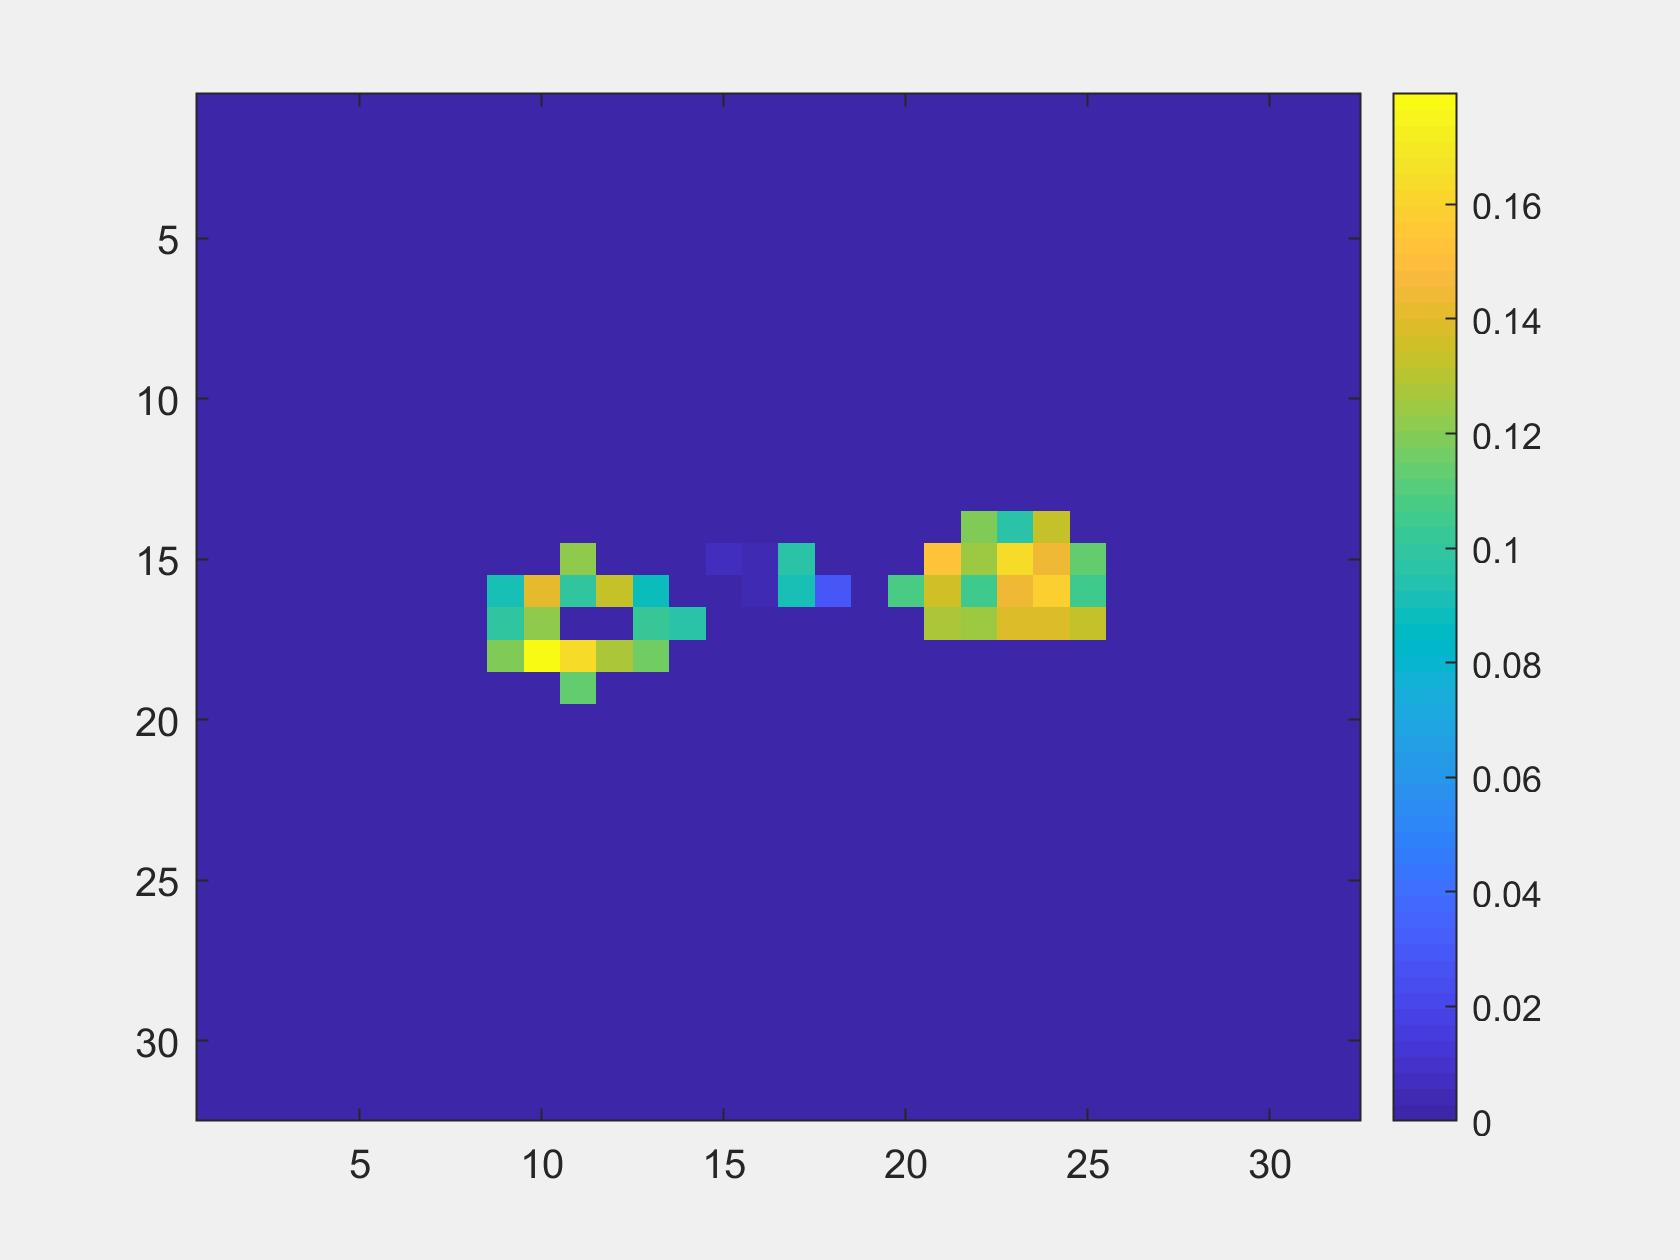

In [71]:
%% Compute kPL and display kPL maps
% use fit_pyr_kinetics, with fixed T1 values 
% create a signal mask to only fit and show relevant voxels

%estimated values for relaxation and rate constants
R1P_est = 1 / 20; R1L_est = 1 / 25; 
kPL_est = 0.002; 

%fixed parameters
params_fixed.R1P = R1P_est; params_fixed.R1L = R1L_est;

%fit parameters
params_est.kPL = kPL_est;

flips = [flips_pyr'; flips_lac']; %restructure given flip angles

% mask out voxels that do not have sufficient pyruvate SNR
nx = size(pyr, 1); ny = size(pyr, 2);
pyr_AUC = sum(pyr, 3);
pyr_max = max(pyr_AUC(:));
ind = find(pyr_AUC >= 0.15*pyr_max); 
S_flat = reshape(S, [nx*ny, size(S,3), size(S,4)]);
S_masked = S_flat(ind, :, :);

[params_fit, Sfit, ufit, error_metrics] = fit_pyr_kinetics(S_masked, TR, flips, params_fixed, params_est);

%construct kPL map
kpl_map = zeros([nx*ny, 1]);
kpl_map(ind) = params_fit.kPL;
kpl_map = reshape(kpl_map, [nx ny]);
figure()
imagesc(kpl_map)
colormap('hot')
colorbar


params_fixed = 

  struct with fields:

    R1P: 0.0500
    R1L: 30

0% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

2% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

4% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

7% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

9% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

11% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

14% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

16% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

19% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

21% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

23% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

26% complete
28% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

30% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)


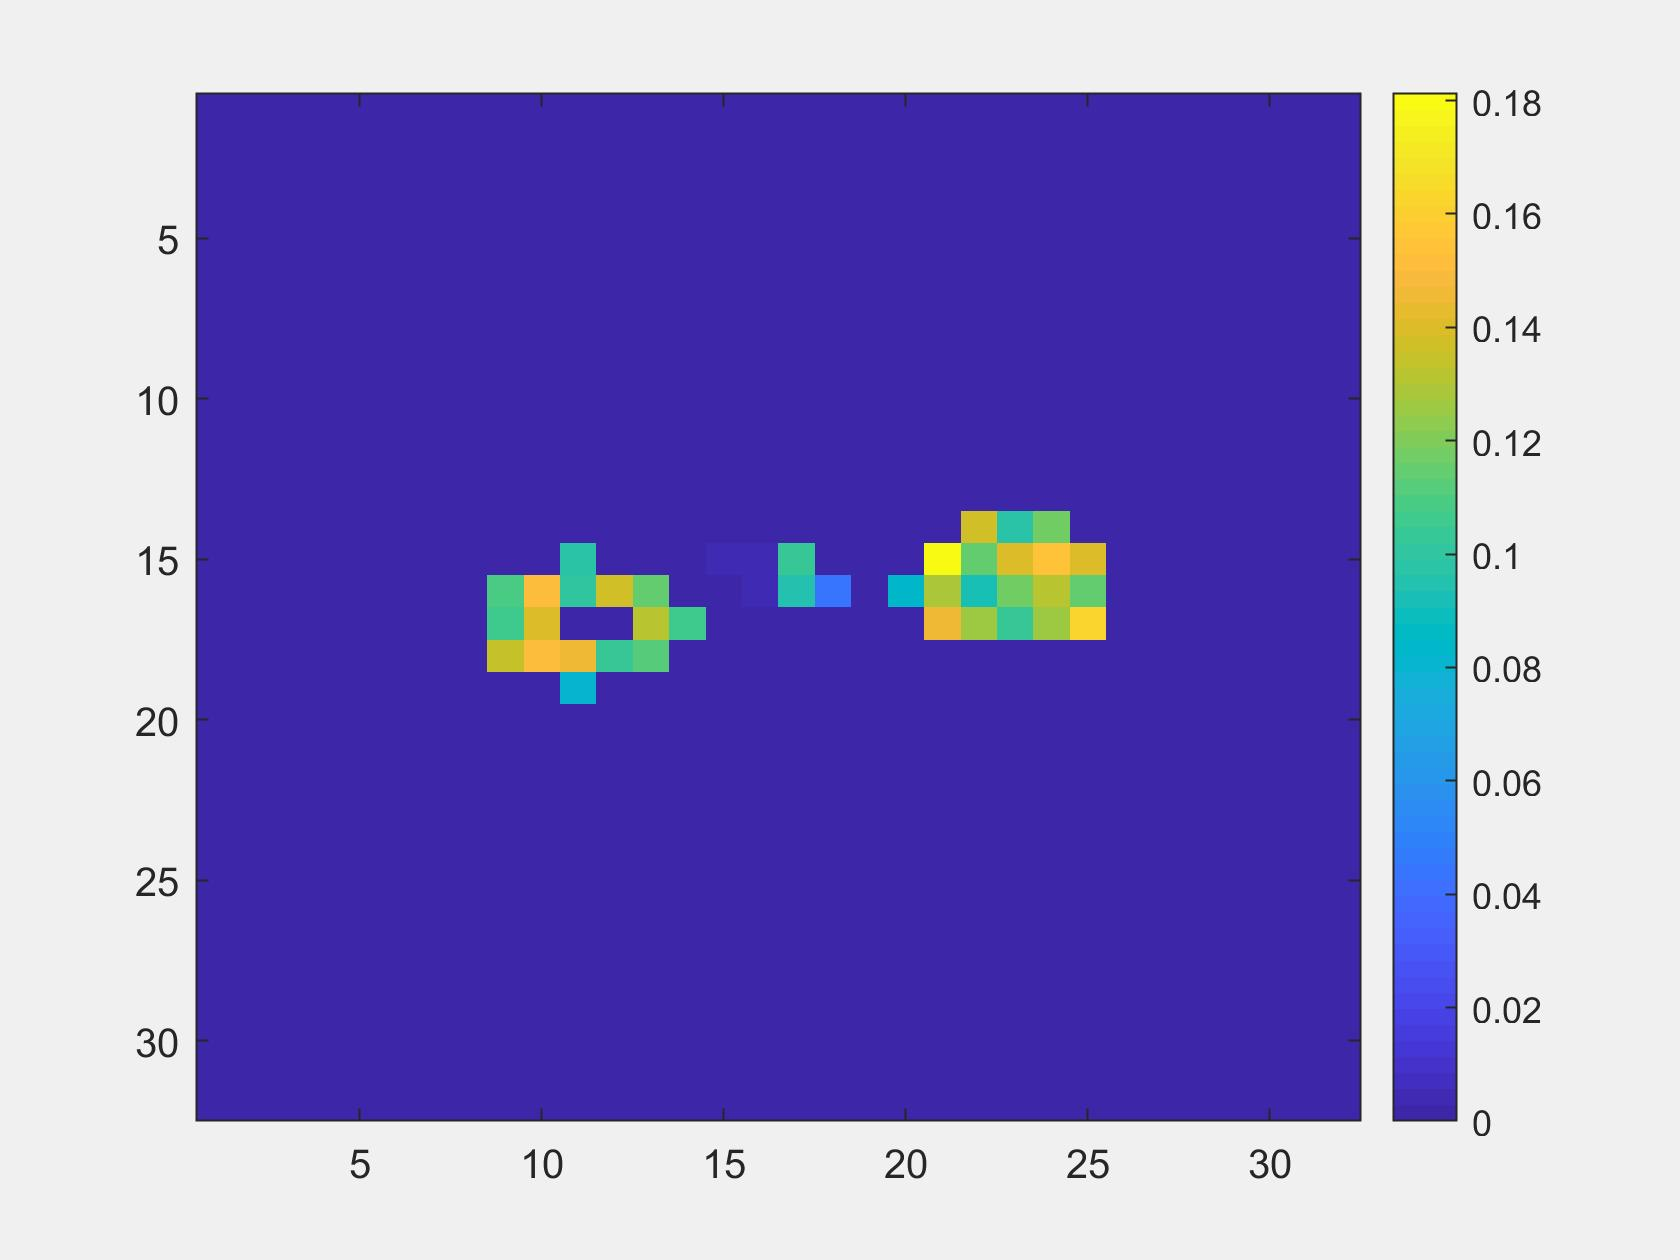

In [73]:
%% Compute kPL with different fixed T1 values
clear params_est, params_fixed
%estimated values for relaxation and rate constants
R1P_est = 1 / 25; R1L_est = 1 / 30; 
kPL_est = 0.002; 

%fixed parameters
params_fixed.R1P = R1P_est; params_fixed.R1L = R1L_est;

%fit parameters
params_est.kPL = kPL_est;

[params_fit, Sfit, ufit, error_metrics] = fit_pyr_kinetics(S_masked, TR, flips, params_fixed, params_est);

%construct kPL map
kpl_map = zeros([nx*ny, 1]);
kpl_map(ind) = params_fit.kPL;
kpl_map = reshape(kpl_map, [nx ny]);
figure()
imagesc(kpl_map)
colormap('hot')
colorbar


params_fixed = 

  struct with fields:

    R1P: 0.0400
    R1L: 0.0333

0% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

2% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

4% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

7% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

9% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

11% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

14% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

16% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

19% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

21% complete
23% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

26% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

28% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 201)

30% complete
> In nlparci (line 108)
  In fit_pyr_kinetics (line 2

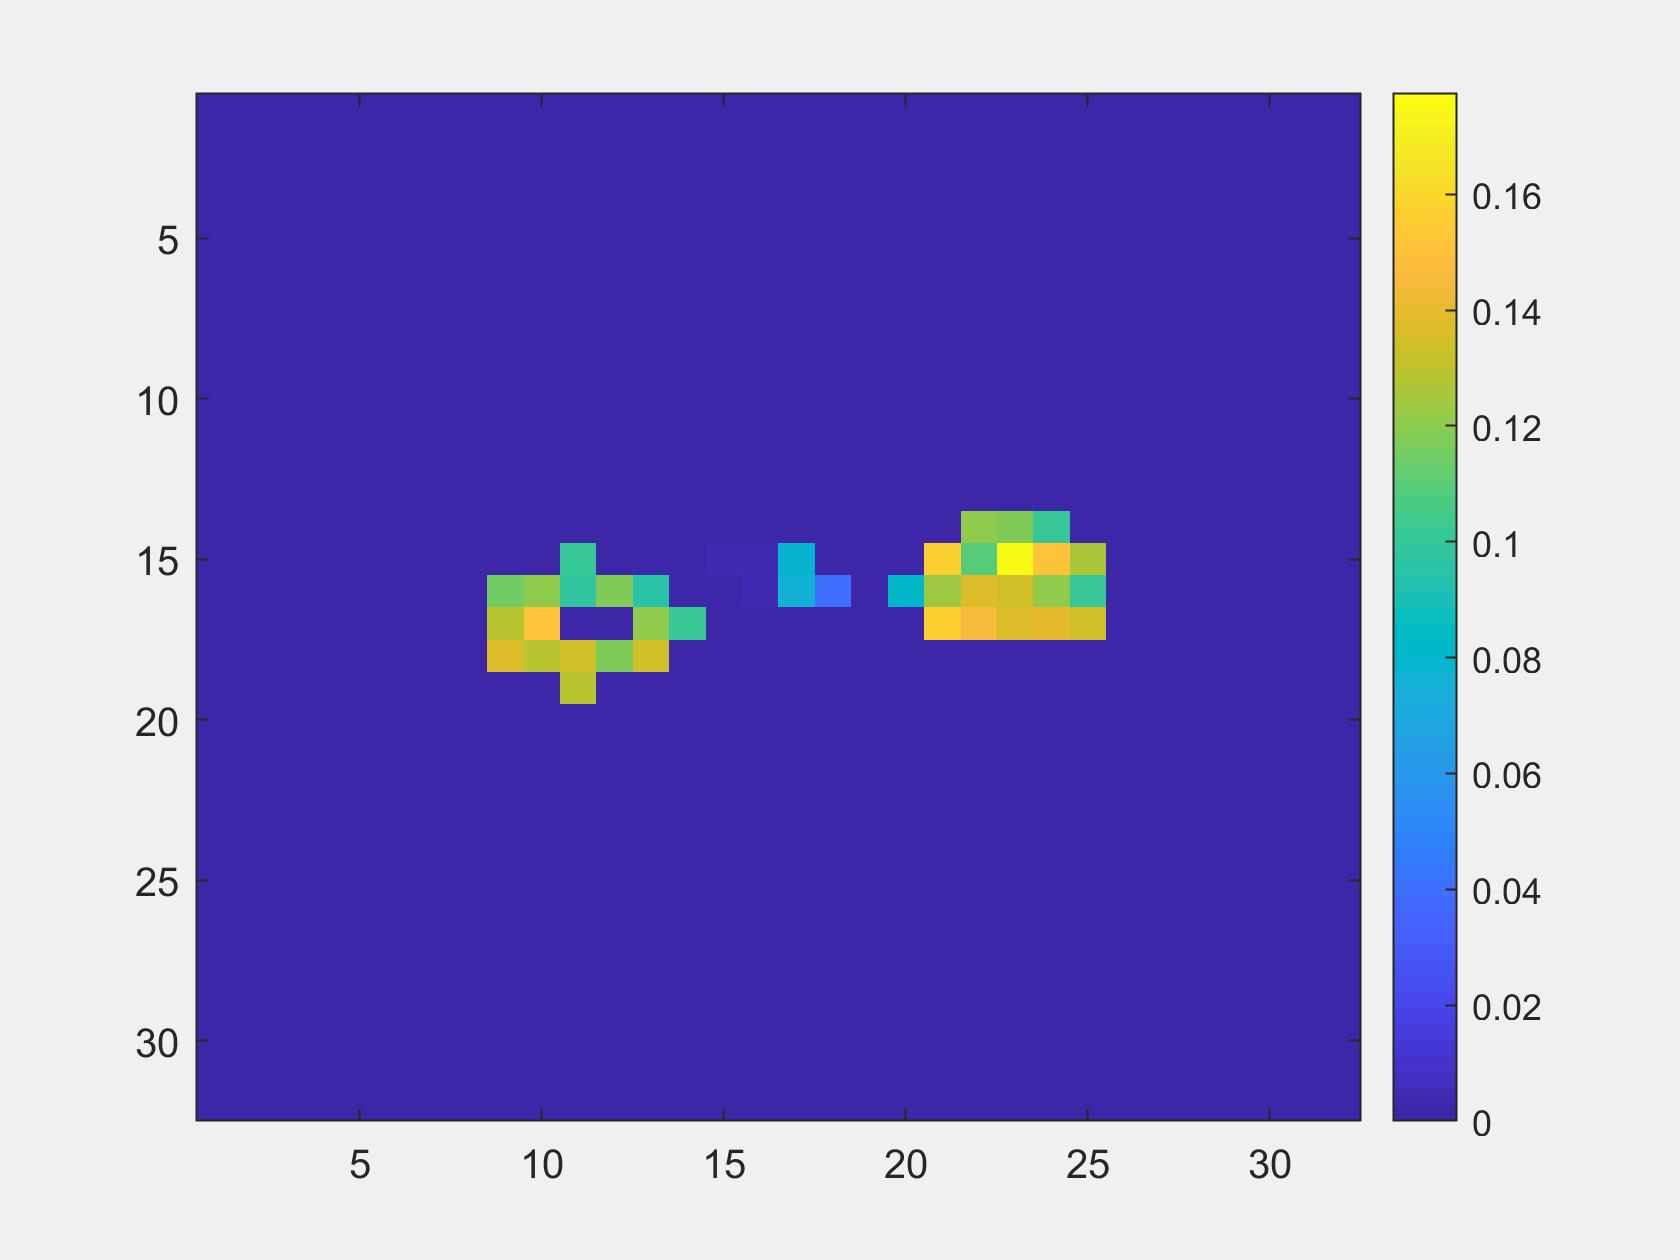

In [74]:
%% Compute kPL while fitting (not fixing) T1 values 
clear params_est, params_fixed
%estimated values for relaxation and rate constants
R1P_est = 1 / 20; R1L_est = 1 / 25; 
kPL_est = 0.002; 

%fixed parameters
params_fixed.R1P = R1P_est; 

%fit parameters -- this time fit lactate T1 as well
params_est.kPL = kPL_est; params_est.R1L = R1L_est;

[params_fit, Sfit, ufit, error_metrics] = fit_pyr_kinetics(S_masked, TR, flips, params_fixed, params_est);

%construct kPL map
kpl_map = zeros([nx*ny, 1]);
kpl_map(ind) = params_fit.kPL;
kpl_map = reshape(kpl_map, [nx ny]);
figure()
imagesc(kpl_map)
colormap('hot')
colorbar

## Exercise: Load and visualize a HP spectroscopy dataset



In [3]:
%% Load a spectroscopic imaging dataset
% sample_data available in toolbox
% Options: human prostate dynamic MRSI, spectral data is [f,x,y,t]

clear all; % clean up workspace
load('sample_data\Human Prostate Dynamic MRSI\pc6071_spectra.mat')

% list all variables
whos

  Name           Size                    Bytes  Class     Attributes

  Nt             1x1                         8  double              
  flips          2x192                    3072  double              
  spectra      256x8x18x24            14155776  double    complex   



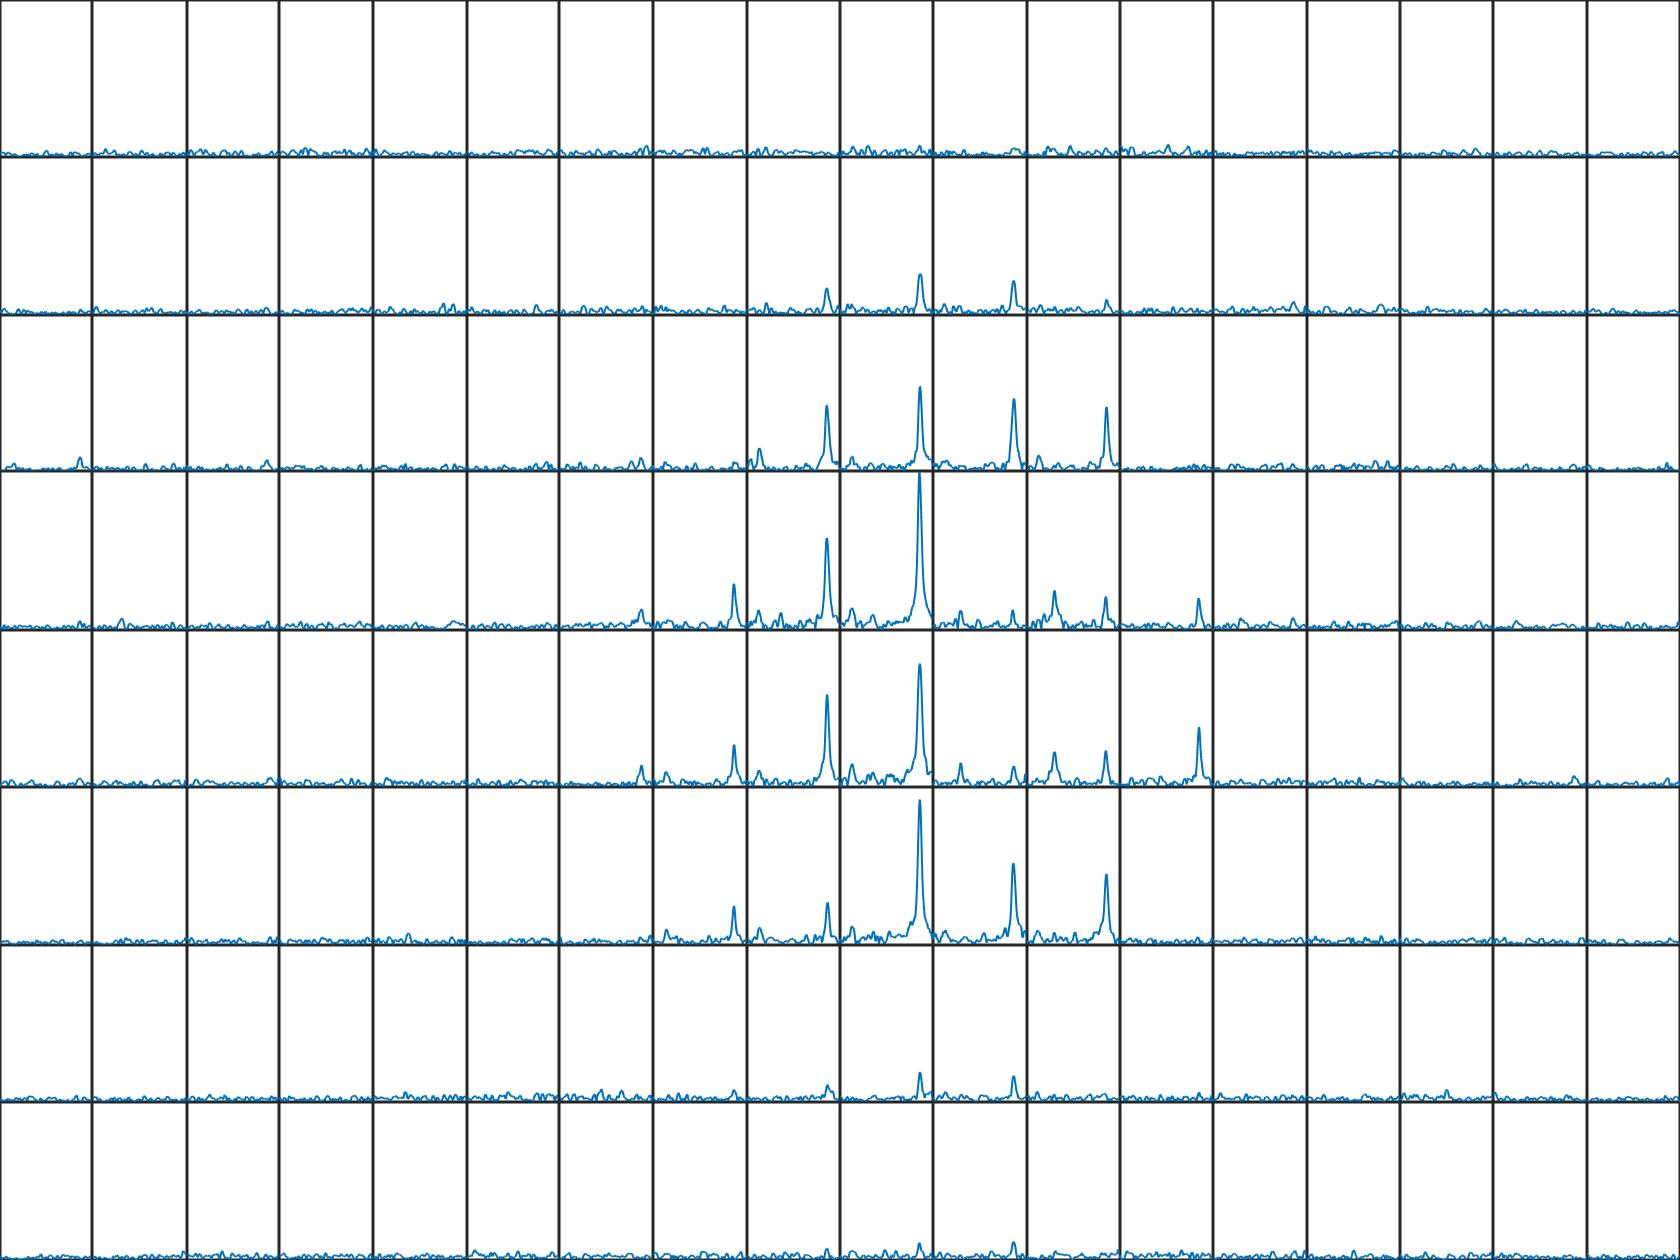

In [8]:
%% Visualize dataset
% for all, find areas that have signal

% 1. use plot_voxels() to show all spectra at a given time point
% may require using permute() to match dimensionality

S_new = permute(abs(spectra(:,:,:,7)), [2 3 1]); %for 7th time point
figure()
plot_voxels(S_new)

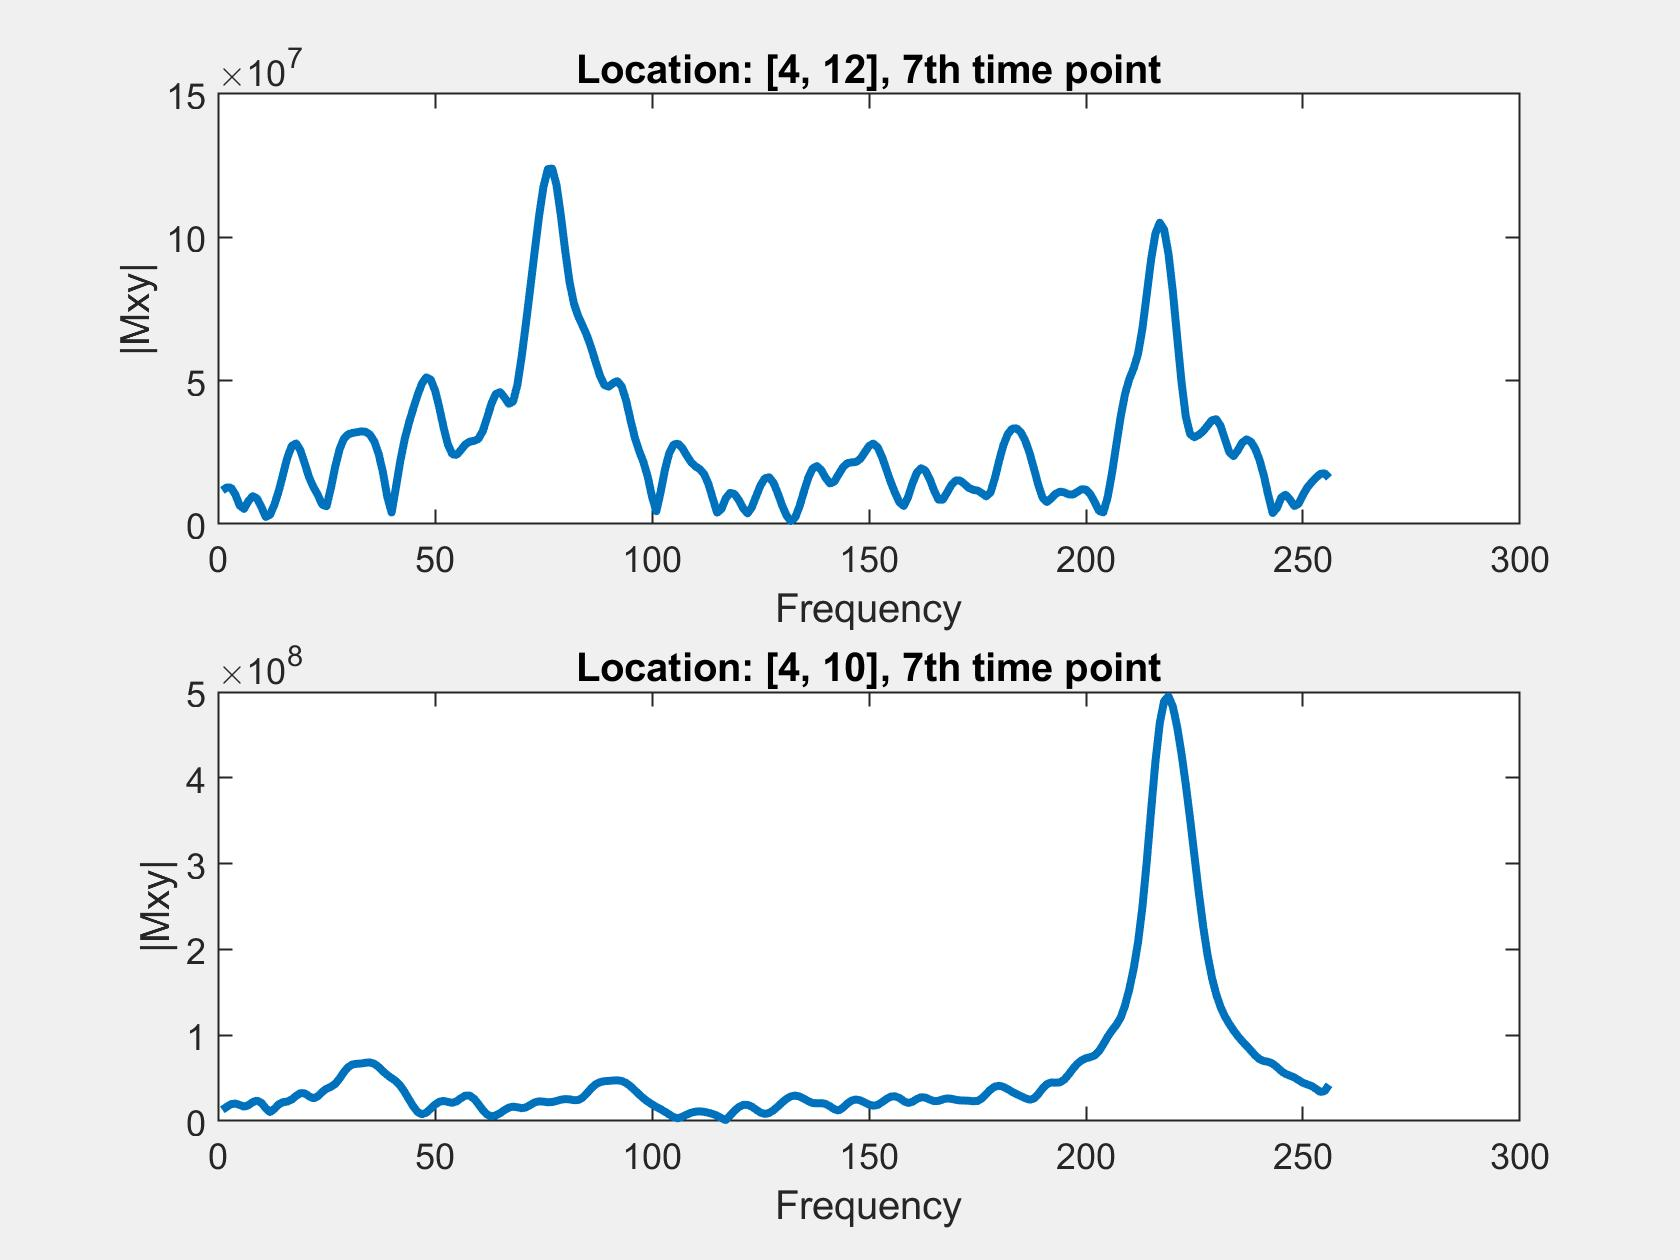

In [9]:
% 2. display a spectrum from a single voxel at a single time-point

single_spectrum_1 = squeeze(abs(spectra(:,4,12,7)));
single_spectrum_2 = squeeze(abs(spectra(:,4,10,7)));
figure()
subplot(211)
plot(1:size(spectra,1), single_spectrum_1, 'LineWidth', 2)
xlabel('Frequency')
ylabel('|Mxy|')
title('Location: [4, 12], 7th time point')
subplot(212)
plot(1:size(spectra,1), single_spectrum_2, 'LineWidth', 2)
xlabel('Frequency')
ylabel('|Mxy|')
title('Location: [4, 10], 7th time point')

In [10]:
%% Extract metabolite maps

% 1. measure a metabolite (e.g. pyruvate) peak location from a single voxel spectrum
[M, Ipyr] = max(single_spectrum_1);
[M, Ilac] = max(single_spectrum_2);

% 2. compute peak heights for all voxels and time-points
% use max() with an input of the measured peak location + [-5,5] to account for inhomogeneity
pyr_peaks = max(abs(spectra(Ipyr-5:Ipyr+5, :, :, :)), [],1);
lac_peaks = max(abs(spectra(Ilac-5:Ilac+5, :, :, :)), [],1);


In [17]:
% 2. (bonus) integrate peak area from phased spectra

% find_phase_corr() function maybe helpful
Ifit = [Ipyr-25:Ipyr+25, Ilac-25:Ilac+25]; %define frequency regions of interest

%apply phase correction
phase_corr = zeros(size(spectra,2), size(spectra,3));
for a=1:size(spectra,2)
    for b=1:size(spectra,3)
        spec = spectra(Ifit,a,b,:); %only apply phase corr for freq range of interest
        phase_corr(a,b) = find_phase_corr(spec(:)); %find zero order phase correction
        
        spectra(:,a,b,:) = spectra(:,a,b,:) * exp(1i*phase_corr(a,b)); %apply phase corr for one location
    end
end

%integrate peak area using corrected spectra
pyr_area = abs(sum(spectra(Ifit(1), :, :, :), 1));
lac_area = abs(sum(spectra(Ifit(2), :, :, :), 1));


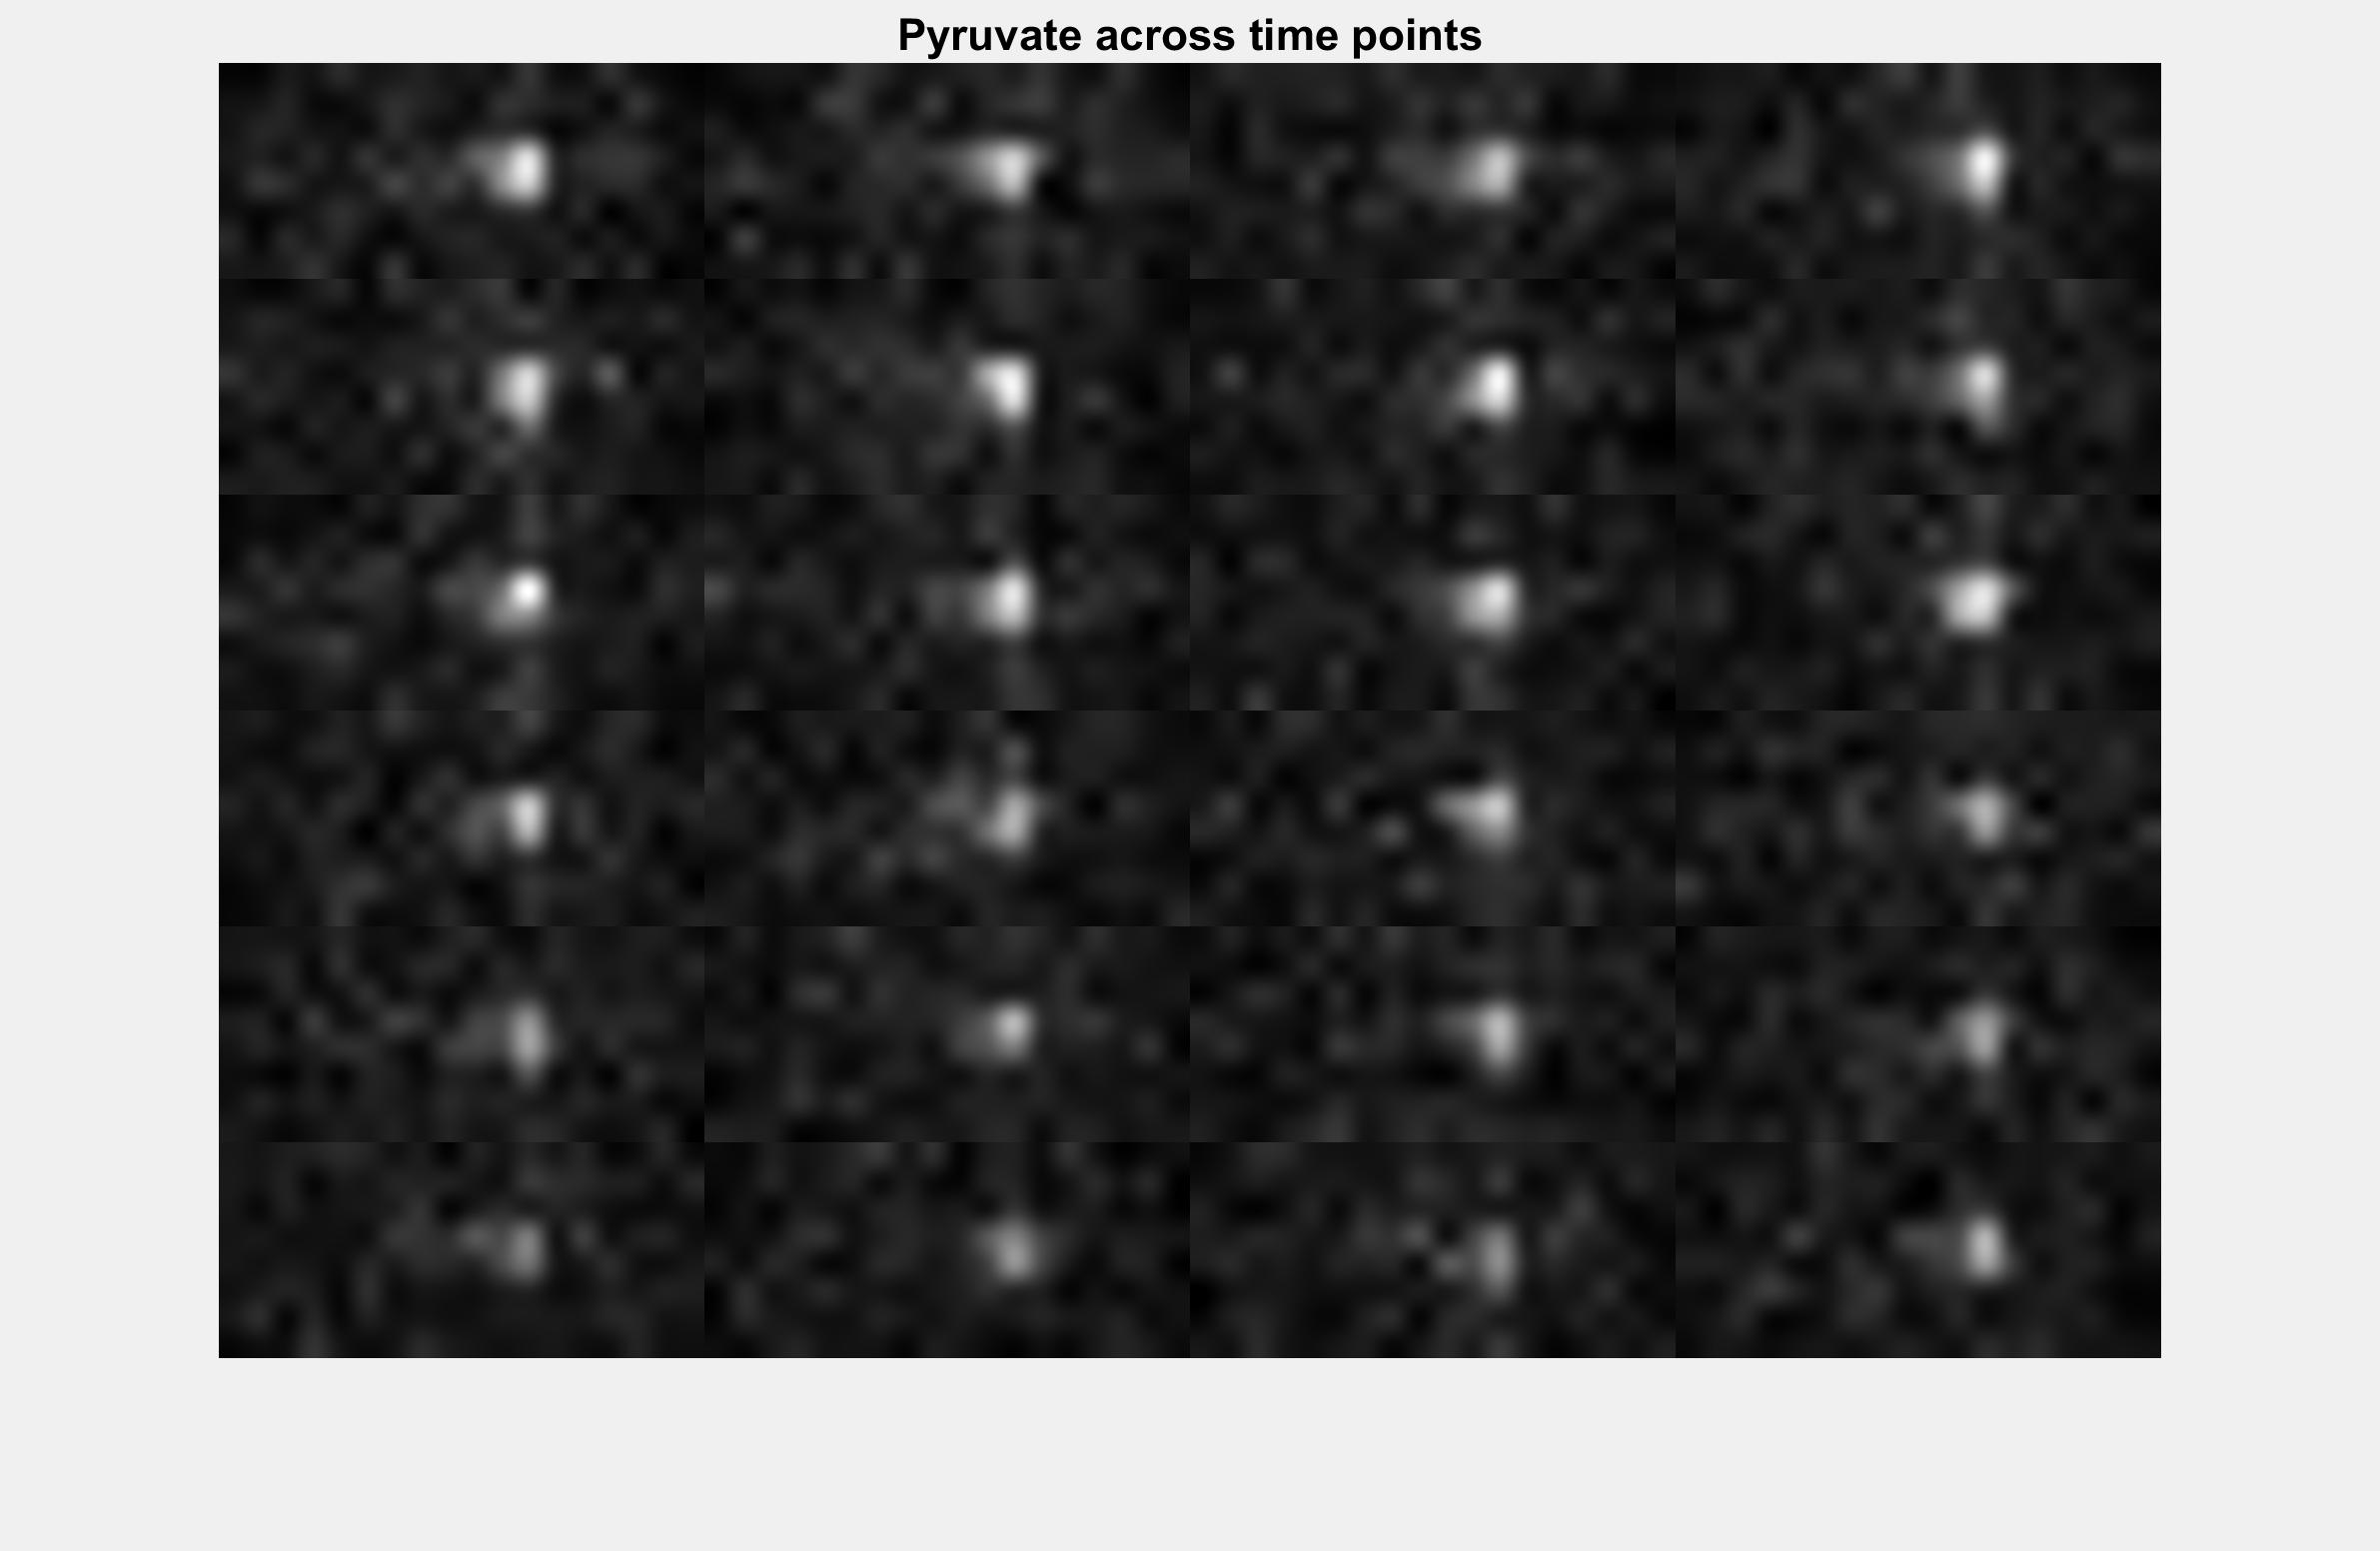

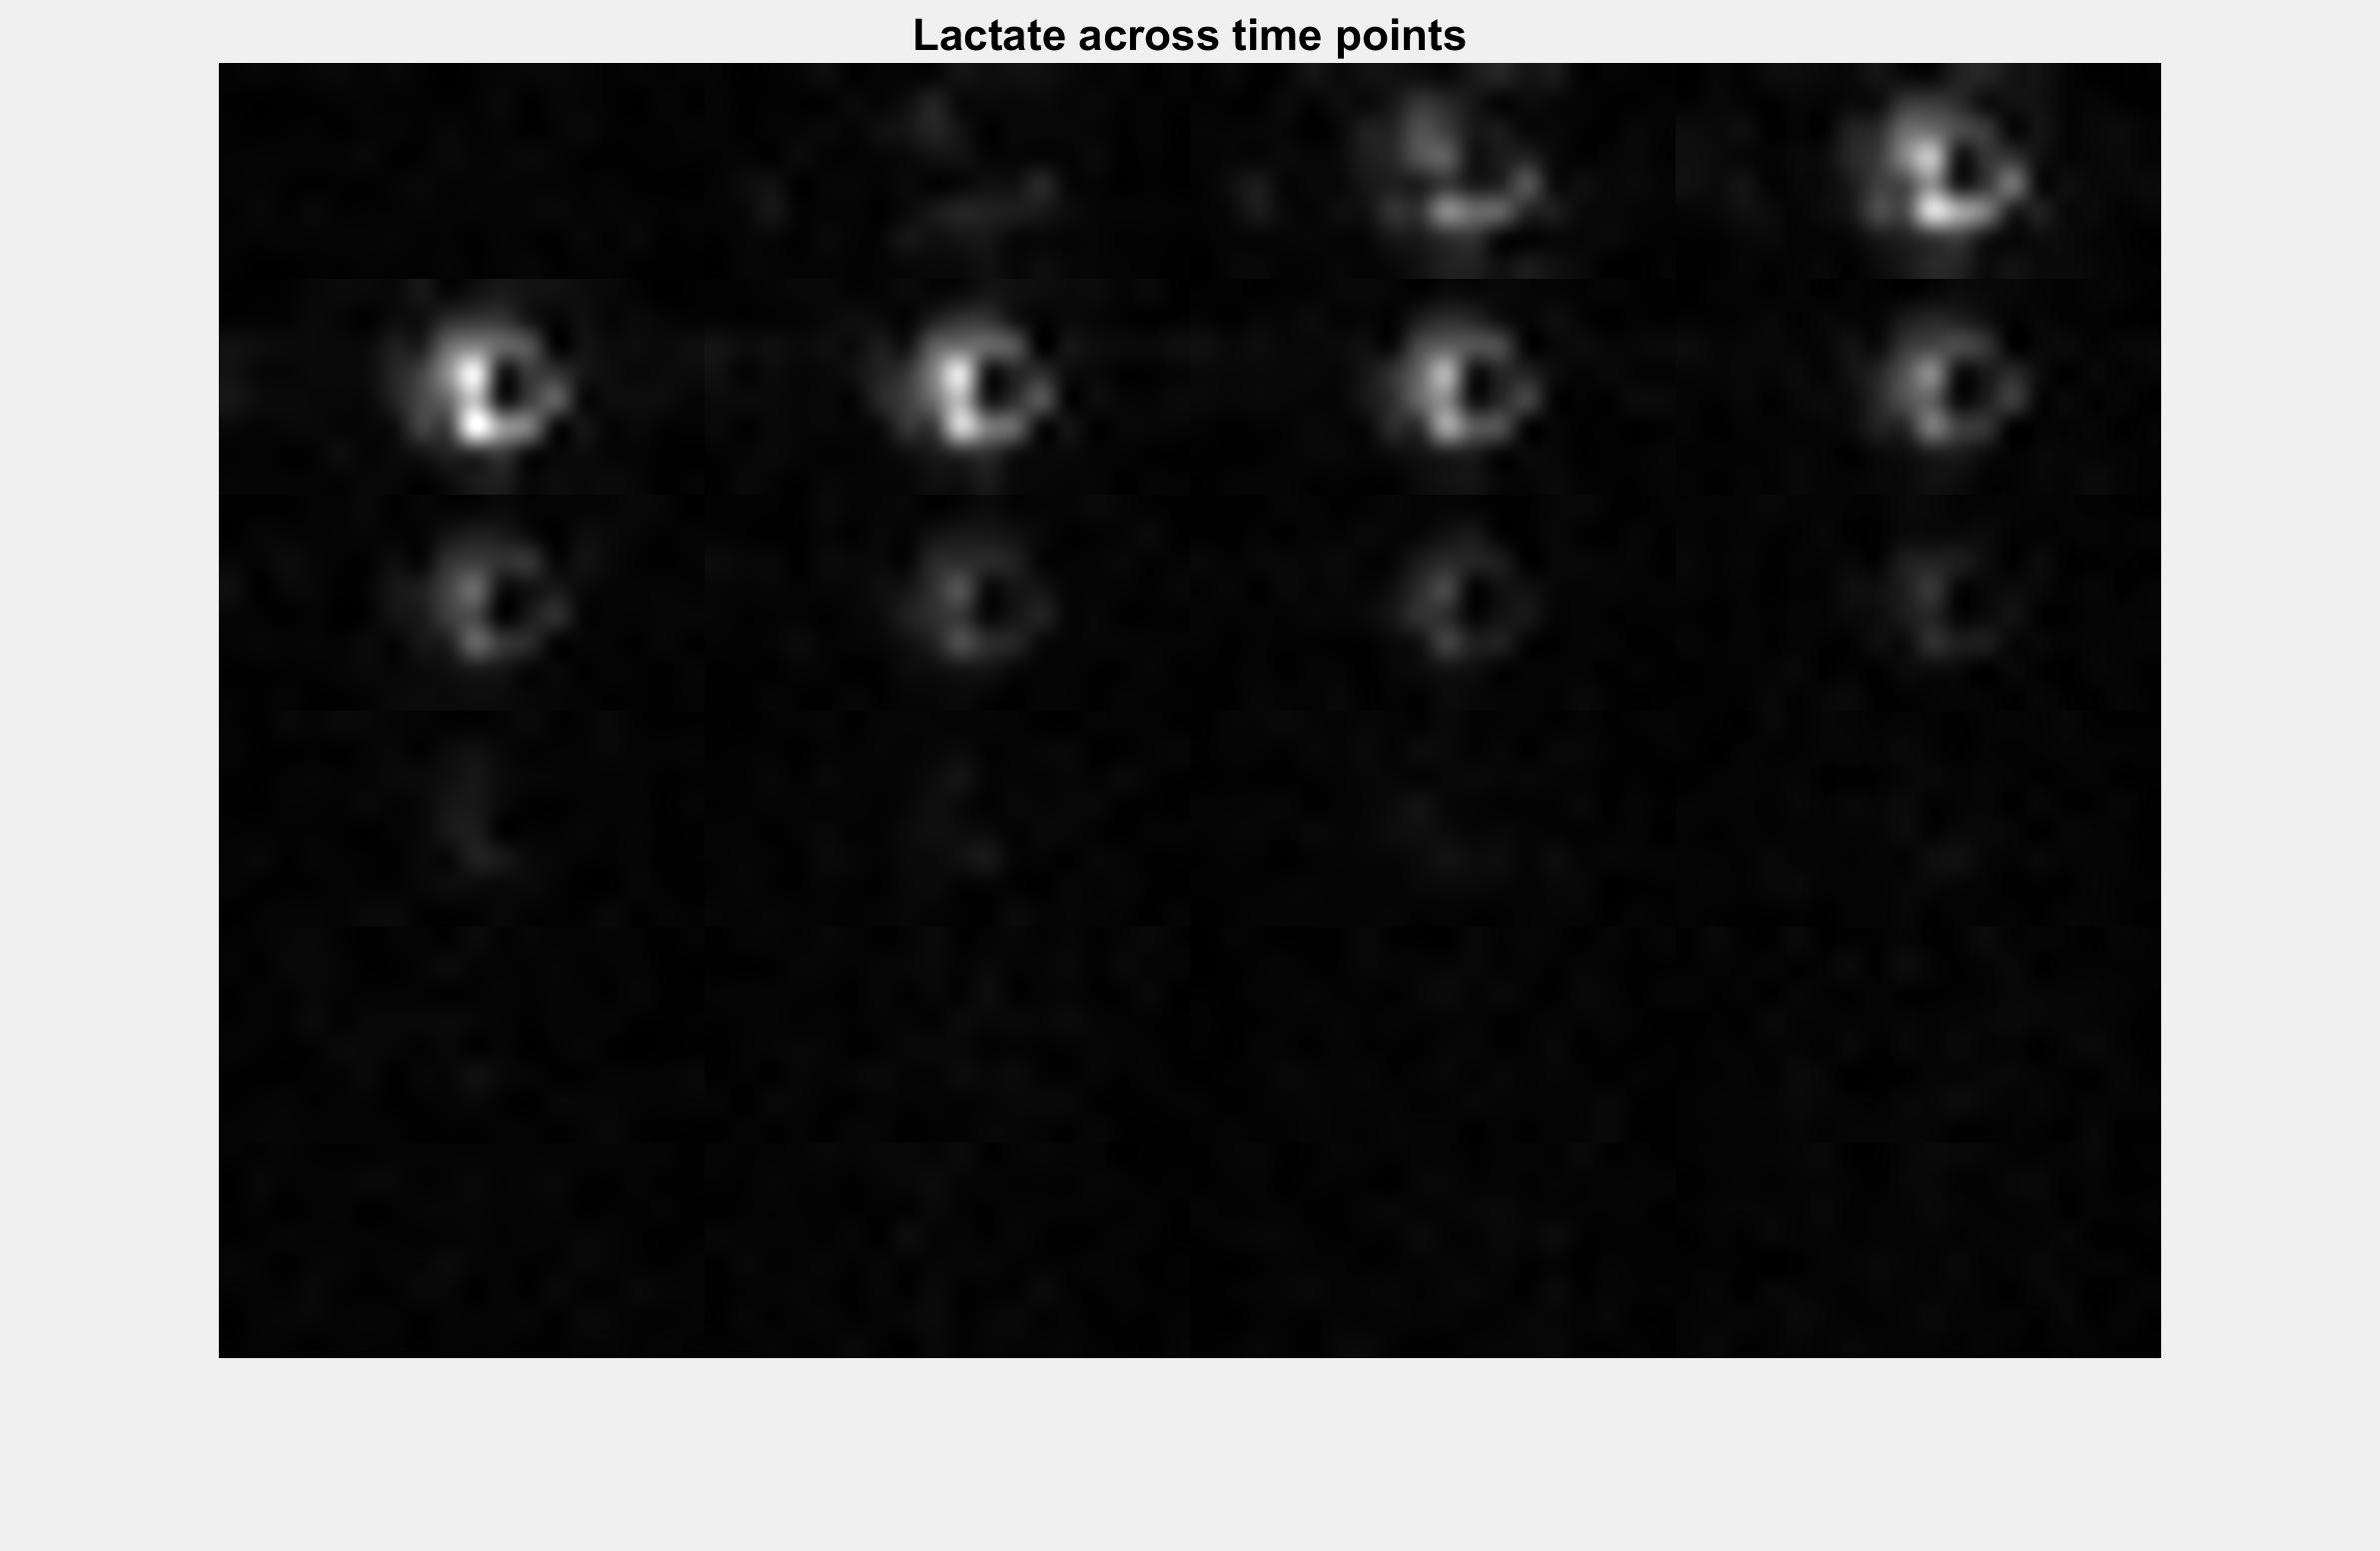

In [16]:
%% Visualize Images
% 1. display a metabolite image for all time-points
pyr_peaks_montage = permute(pyr_peaks, [2 3 1 4]);
lac_peaks_montage = permute(lac_peaks, [2 3 1 4]);

figure()
montage(pyr_peaks_montage, 'DisplayRange', [min(pyr_peaks(:)) max(pyr_peaks(:))])
title('Pyruvate across time points')

figure()
montage(lac_peaks_montage, 'DisplayRange', [min(lac_peaks(:)) max(lac_peaks(:))])
title('Lactate across time points')


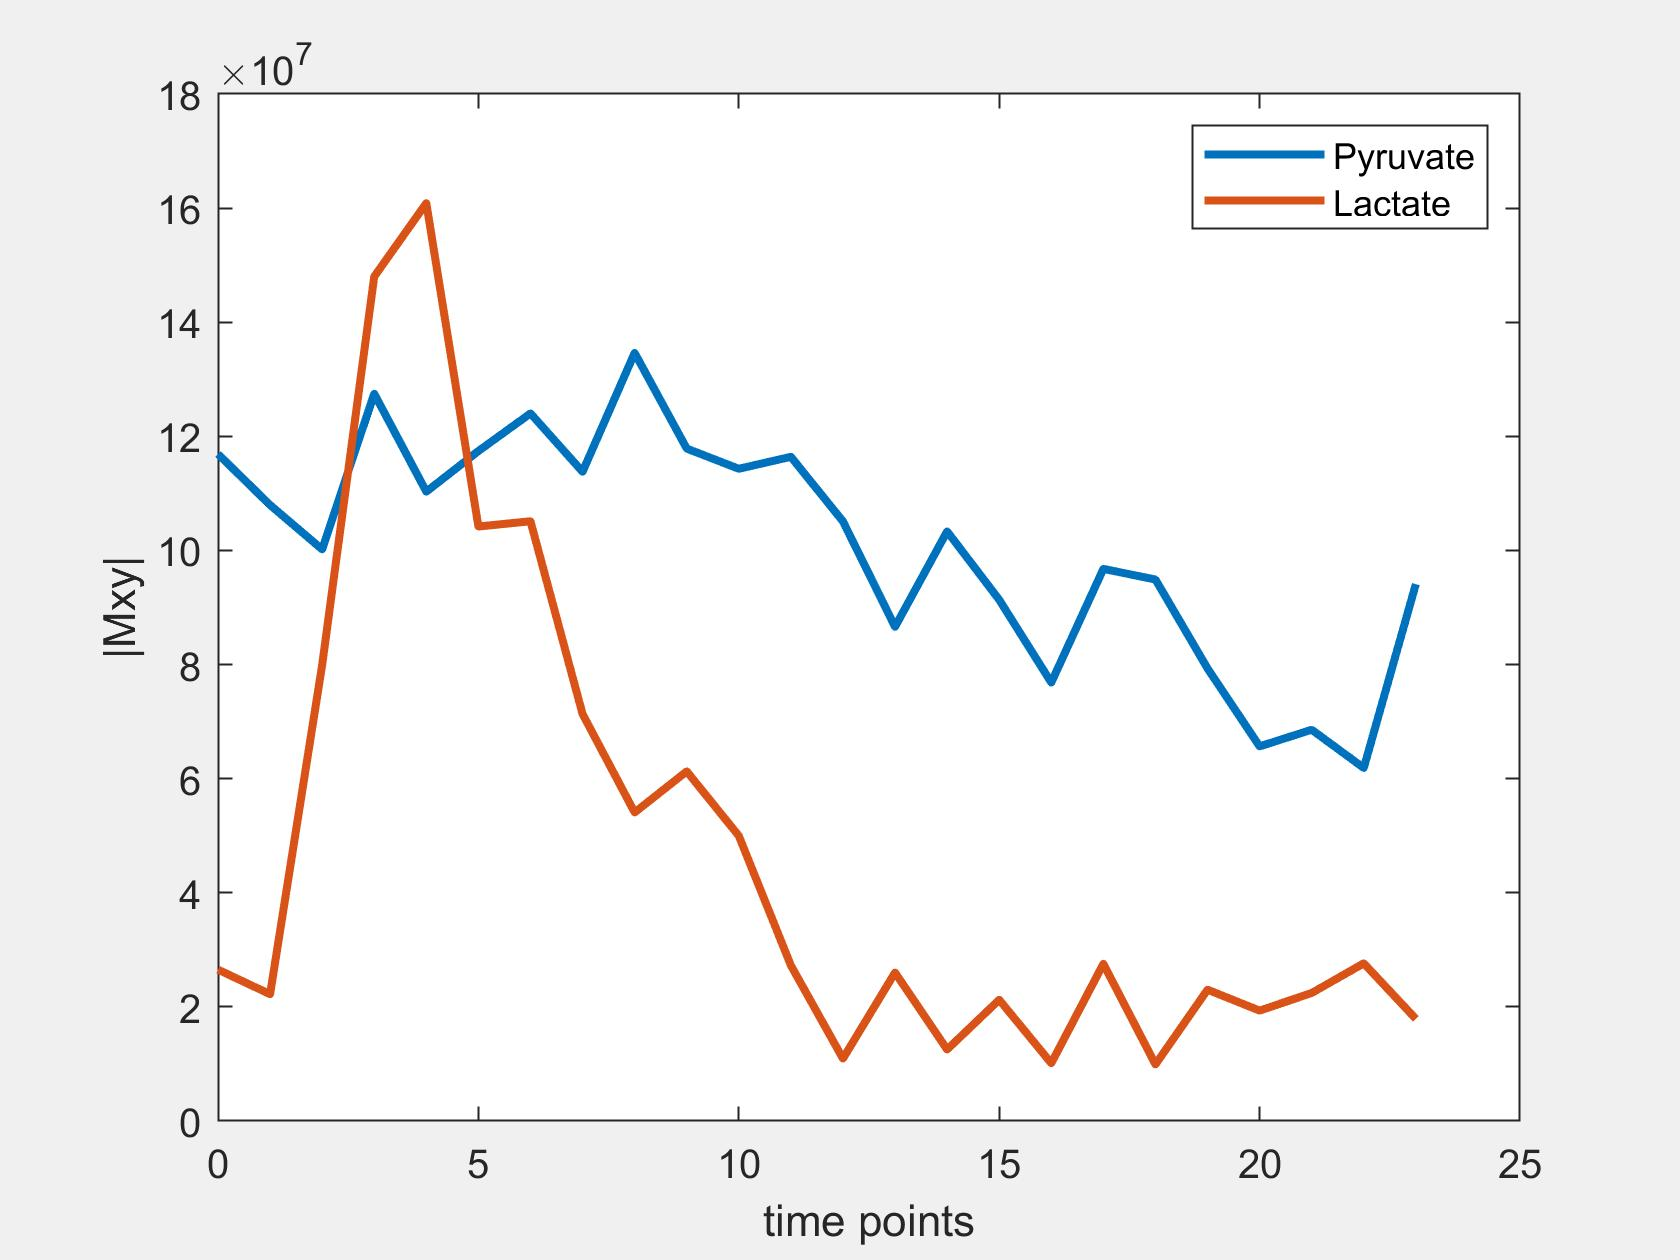

In [143]:
% 2. extract the time curves from a single voxel, and plot

vx = [4, 12]; %arbitratrily pick one of the voxels with signal
pyr_time = squeeze(pyr_peaks(:, vx(1), vx(2), :));
lac_time = squeeze(lac_peaks(:, vx(1), vx(2), :));
time = 0:Nt-1;

figure()
plot(time, pyr_time, time, lac_time, 'LineWidth', 2)
legend('Pyruvate', 'Lactate')
xlabel('time points')
ylabel('|Mxy|')